CIFAR

In [3]:
import torch
import os
import opacus
import copy
import torchvision
import random
import torchattacks

import numpy as np
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler

from tqdm import tqdm
from datetime import datetime
from opacus.validators import ModuleValidator
from opacus.utils.batch_memory_manager import BatchMemoryManager

from model import ResNet9, initialize_weights
from adv import Attack, adv_test

seed = 34
torch.cuda.empty_cache()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.deterministic = True
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [4]:
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD_DEV = (0.2023, 0.1994, 0.2010)

class Experiment_weighted:
    def __init__(self, batch_size, epochs, adv_attack, adv_attack_mode, adv_params, device, save_experiment,
                 verbose, dp = True, target_epsilon=7.5, dataset='cifar', adv_test=True, name=None, max_batch_size=512):
        if dataset == 'cifar':
            self.model = ResNet9(norm_layer="group")
            self.adv_model = ResNet9(norm_layer="group").to(device)
        else:
            self.model = ResNet9(in_channels=1, norm_layer="group")
            self.adv_model = ResNet9(in_channels=1, norm_layer="group").to(device)
        self.optimizer = optim.NAdam(self.model.parameters())
        self.lr_scheduler = lr_scheduler.ReduceLROnPlateau(self.optimizer)
        self.criterion = nn.CrossEntropyLoss()
        self.batch_size = batch_size
        self.epochs = epochs
        self.attack = Attack(adv_attack, adv_params, device) if adv_attack is not None else None
        self.adv_attack_mode = adv_attack_mode
        self.dp = dp
        self.device = device
        self.verbose = verbose
        self.disable_tqdm = not self.verbose
        self.save_experiment = save_experiment
        self.target_epsilon = target_epsilon
        self.dataset = dataset
        self.adv_test = adv_test
        self.max_batch_size = max_batch_size
        self.best_model_weights = None


        if name is None:
            adv_s = f"adv-{adv_attack_mode}" if adv_attack is not None else "non_adv"
            dp_s = "dp" if dp else "non_dp"
            self.name = f"{dataset}+{adv_s}+{dp_s}+{batch_size}"
        else:
            self.name = name

        now = datetime.now()
        formatted_timestamp = now.strftime("%d-%m-%Y_%H:%M:%S")
        self.dir_name = f"results/{self.name}_{formatted_timestamp}"
        if self.save_experiment:
            os.makedirs(self.dir_name, exist_ok=True)

        self._setup_training()

    def _log(self, message):
        print(f"Experiment {self.name}: {message}")

    def _setup_training(self):
        self._log("Loading data")
        if self.dataset == 'cifar':
            transform = transforms.Compose(
                [transforms.ToTensor(),
                transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD_DEV) 
                ])
            learning_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

            # train_set, val_set = torch.utils.data.random_split(learning_set, [35000, 15000],
            #                                                 generator=torch.Generator().manual_seed(42))
            test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
            self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
        else:
            transform = transforms.Compose(
                [transforms.ToTensor(),
                ])
            learning_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
            # train_set, val_set = torch.utils.data.random_split(learning_set, [40000, 20000],
            #                                                generator=torch.Generator().manual_seed(42))
            test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
            self.classes = (x for x in range(0,9))

        self.train_loader = torch.utils.data.DataLoader(learning_set, batch_size=self.batch_size, shuffle=True,
                                                        num_workers=2)
        # self.val_loader = torch.utils.data.DataLoader(val_set, batch_size=self.batch_size, num_workers=2)
        # self.val_loader_x1 = torch.utils.data.DataLoader(val_set, batch_size=1, num_workers=2)
        self.test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, num_workers=2)


        if self.dp:
            self._log("DP on")
            self.privacy_engine = opacus.PrivacyEngine()
            self.model, self.optimizer, self.train_loader = self.privacy_engine.make_private_with_epsilon(
                module=self.model,
                optimizer=self.optimizer,
                data_loader=self.train_loader,
                epochs=self.epochs,
                target_epsilon=self.target_epsilon,
                target_delta=1e-5,
                max_grad_norm=1.2,
                noise_generator=torch.Generator(device=self.device).manual_seed(seed)
            )
            self.lr_scheduler = lr_scheduler.ReduceLROnPlateau(self.optimizer)
        else:
            self._log("DP off")

    def _fit(self):
        self._log("Training started")
        _ = self.model.to(self.device)
        _ = self.model.apply(initialize_weights)

        train_losses = []
        train_accuracies = []
        val_losses = []
        val_accuracies = []

        for epoch in range(self.epochs):

            if self.dp:
                with BatchMemoryManager(
                        data_loader=self.train_loader,
                        max_physical_batch_size=self.max_batch_size,
                        optimizer=self.optimizer
                ) as new_train_loader:
                    train_loss, train_acc = self._run_epoch(new_train_loader)
            else:
                train_loss, train_acc = self._run_epoch(self.train_loader)

            self._log(f"Epoch {epoch + 1: >3}/{self.epochs}, train loss: {train_loss:.2e}, train acc: {train_acc:.3f}")

            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
#             self.lr_scheduler.step(train_loss)
            
            val_loss, val_acc = self._run_epoch(self.test_loader, eval=True)
            self.lr_scheduler.step(val_loss)
            
            self._log(f"Epoch {epoch + 1: >3}/{self.epochs}, val loss: {val_loss:.2e}, val acc: {val_acc:.3f}")
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)

        self._plot(range(len(train_losses)), np.array(train_losses), 'train_loss')
        self._plot(range(len(train_accuracies)), np.array(train_accuracies), 'train_acc')
        self._plot(range(len(val_losses)), np.array(val_losses), 'val_loss')
        self._plot(range(len(val_accuracies)), np.array(val_accuracies), 'val_acc')

    def _plot(self, x, y, title):
        plt.plot(range(len(x)), np.array(y))
        plt.title(title)
        if self.save_experiment:
            plt.savefig(f"{self.dir_name}/{title}.png")
        if self.verbose:
            plt.show()
        else:
            plt.clf()

    def _run_epoch(self, data_loader, eval=False):
        if eval:
            self.model.eval()
        else:
            self.model.train()

        dataset_len = len(data_loader.dataset)

        epoch_loss = 0.0
        epoch_acc = 0.0

        for inputs, targets in tqdm(data_loader, disable=self.disable_tqdm):
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            if self.dp:
                self.adv_model.load_state_dict(copy.deepcopy(self.model._module.state_dict()))
                model = self.adv_model
            else:
                model = self.model

            inputs_adv, _ = self.attack.perturbe(inputs, targets, model, self.adv_attack_mode)

            self.optimizer.zero_grad()

            outputs = self.model(inputs)
            loss = self.criterion(outputs, targets)

            top1 = torch.argmax(outputs, dim=1).long()
            n_correct = torch.sum(top1 == targets)
            epoch_loss += loss.item()
            epoch_acc += n_correct.item()
            
            outputs_adv = self.model(inputs_adv)
            loss_adv = self.criterion(outputs_adv, targets)
            
            loss_weighted = (loss * 9 + loss_adv) / 10
#             loss_weighted = loss + loss_adv

            if not eval:
                loss_weighted.backward()
                self.optimizer.step()

        epoch_loss /= dataset_len
        epoch_acc /= dataset_len

        return epoch_loss, epoch_acc

    def run(self):
        self._fit()

        self._log(f"Train accuracy: {self._run_epoch(self.train_loader, eval=True)}")
        epsilon = self.privacy_engine.get_epsilon(1e-5)
        self._log(f"Training finished with epsilon {epsilon}")
        
        # if self.adv_test:
        #     adv_test(self.model, self.val_loader_x1, self.classes, self.device, self.attack)

       

cuda
Experiment cifar+non_adv+dp+1024: Loading data
Files already downloaded and verified
Files already downloaded and verified


/home/anna/miniconda3/envs/ap/lib/python3.10/site-packages/opacus/privacy_engine.py:141: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/home/anna/miniconda3/envs/ap/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


Experiment cifar+non_adv+dp+1024: DP on
Experiment cifar+non_adv+dp+1024: Training started


  0%|                                                                                                     | 0/195 [00:00<?, ?it/s]/home/anna/miniconda3/envs/ap/lib/python3.10/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
215it [00:16, 13.26it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch   1/50, train loss: 1.17e-02, train acc: 0.258


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:45<00:00, 217.49it/s]


Experiment cifar+non_adv+dp+1024: Epoch   1/50, val loss: 1.92e+00, val acc: 0.370


218it [00:14, 14.72it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch   2/50, train loss: 8.28e-03, train acc: 0.397


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:46<00:00, 215.56it/s]


Experiment cifar+non_adv+dp+1024: Epoch   2/50, val loss: 1.87e+00, val acc: 0.424


214it [00:14, 14.52it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch   3/50, train loss: 7.83e-03, train acc: 0.442


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:46<00:00, 217.22it/s]


Experiment cifar+non_adv+dp+1024: Epoch   3/50, val loss: 1.96e+00, val acc: 0.454


218it [00:14, 14.66it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch   4/50, train loss: 7.85e-03, train acc: 0.474


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:45<00:00, 218.80it/s]


Experiment cifar+non_adv+dp+1024: Epoch   4/50, val loss: 1.79e+00, val acc: 0.497


215it [00:14, 14.63it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch   5/50, train loss: 7.44e-03, train acc: 0.501


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:46<00:00, 215.00it/s]


Experiment cifar+non_adv+dp+1024: Epoch   5/50, val loss: 1.62e+00, val acc: 0.530


219it [00:14, 14.76it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch   6/50, train loss: 7.23e-03, train acc: 0.535


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:46<00:00, 215.44it/s]


Experiment cifar+non_adv+dp+1024: Epoch   6/50, val loss: 1.84e+00, val acc: 0.508


214it [00:14, 14.53it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch   7/50, train loss: 6.89e-03, train acc: 0.548


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:45<00:00, 217.93it/s]


Experiment cifar+non_adv+dp+1024: Epoch   7/50, val loss: 1.80e+00, val acc: 0.523


222it [00:14, 14.91it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch   8/50, train loss: 7.23e-03, train acc: 0.562


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:46<00:00, 216.66it/s]


Experiment cifar+non_adv+dp+1024: Epoch   8/50, val loss: 1.80e+00, val acc: 0.533


224it [00:14, 15.01it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch   9/50, train loss: 7.01e-03, train acc: 0.579


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:46<00:00, 215.62it/s]


Experiment cifar+non_adv+dp+1024: Epoch   9/50, val loss: 1.55e+00, val acc: 0.574


218it [00:14, 14.74it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch  10/50, train loss: 6.70e-03, train acc: 0.583


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:46<00:00, 216.53it/s]


Experiment cifar+non_adv+dp+1024: Epoch  10/50, val loss: 1.51e+00, val acc: 0.584


218it [00:14, 14.76it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch  11/50, train loss: 6.55e-03, train acc: 0.597


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:45<00:00, 218.20it/s]


Experiment cifar+non_adv+dp+1024: Epoch  11/50, val loss: 1.51e+00, val acc: 0.586


213it [00:14, 14.41it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch  12/50, train loss: 6.12e-03, train acc: 0.611


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:45<00:00, 218.10it/s]


Experiment cifar+non_adv+dp+1024: Epoch  12/50, val loss: 1.49e+00, val acc: 0.600


221it [00:14, 14.81it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch  13/50, train loss: 6.38e-03, train acc: 0.622


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:45<00:00, 218.15it/s]


Experiment cifar+non_adv+dp+1024: Epoch  13/50, val loss: 1.57e+00, val acc: 0.595


216it [00:14, 14.62it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch  14/50, train loss: 6.22e-03, train acc: 0.622


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:46<00:00, 216.04it/s]


Experiment cifar+non_adv+dp+1024: Epoch  14/50, val loss: 1.43e+00, val acc: 0.621


220it [00:14, 14.82it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch  15/50, train loss: 6.35e-03, train acc: 0.630


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:45<00:00, 218.63it/s]


Experiment cifar+non_adv+dp+1024: Epoch  15/50, val loss: 1.50e+00, val acc: 0.613


220it [00:14, 14.72it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch  16/50, train loss: 6.23e-03, train acc: 0.645


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:45<00:00, 218.08it/s]


Experiment cifar+non_adv+dp+1024: Epoch  16/50, val loss: 1.44e+00, val acc: 0.630


217it [00:14, 14.60it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch  17/50, train loss: 6.16e-03, train acc: 0.641


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:46<00:00, 217.12it/s]


Experiment cifar+non_adv+dp+1024: Epoch  17/50, val loss: 1.63e+00, val acc: 0.607


207it [00:14, 14.17it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch  18/50, train loss: 5.68e-03, train acc: 0.645


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:45<00:00, 217.40it/s]


Experiment cifar+non_adv+dp+1024: Epoch  18/50, val loss: 1.61e+00, val acc: 0.618


220it [00:14, 14.74it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch  19/50, train loss: 6.07e-03, train acc: 0.657


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:46<00:00, 215.92it/s]


Experiment cifar+non_adv+dp+1024: Epoch  19/50, val loss: 1.48e+00, val acc: 0.637


218it [00:14, 14.62it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch  20/50, train loss: 5.95e-03, train acc: 0.662


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:46<00:00, 217.11it/s]


Experiment cifar+non_adv+dp+1024: Epoch  20/50, val loss: 1.39e+00, val acc: 0.644


226it [00:15, 15.06it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch  21/50, train loss: 6.07e-03, train acc: 0.669


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:45<00:00, 218.15it/s]


Experiment cifar+non_adv+dp+1024: Epoch  21/50, val loss: 1.42e+00, val acc: 0.649


224it [00:15, 14.92it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch  22/50, train loss: 5.95e-03, train acc: 0.677


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:45<00:00, 217.71it/s]


Experiment cifar+non_adv+dp+1024: Epoch  22/50, val loss: 1.62e+00, val acc: 0.625


220it [00:14, 14.79it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch  23/50, train loss: 5.74e-03, train acc: 0.680


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:46<00:00, 216.00it/s]


Experiment cifar+non_adv+dp+1024: Epoch  23/50, val loss: 1.42e+00, val acc: 0.652


221it [00:14, 14.78it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch  24/50, train loss: 5.89e-03, train acc: 0.680


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:46<00:00, 215.09it/s]


Experiment cifar+non_adv+dp+1024: Epoch  24/50, val loss: 1.40e+00, val acc: 0.663


221it [00:14, 14.83it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch  25/50, train loss: 5.80e-03, train acc: 0.687


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:46<00:00, 215.65it/s]


Experiment cifar+non_adv+dp+1024: Epoch  25/50, val loss: 1.46e+00, val acc: 0.651


215it [00:14, 14.49it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch  26/50, train loss: 5.59e-03, train acc: 0.683


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:46<00:00, 213.17it/s]


Experiment cifar+non_adv+dp+1024: Epoch  26/50, val loss: 1.43e+00, val acc: 0.657


221it [00:14, 14.94it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch  27/50, train loss: 5.71e-03, train acc: 0.686


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:46<00:00, 216.11it/s]


Experiment cifar+non_adv+dp+1024: Epoch  27/50, val loss: 1.51e+00, val acc: 0.652


222it [00:14, 14.87it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch  28/50, train loss: 5.95e-03, train acc: 0.691


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:45<00:00, 218.04it/s]


Experiment cifar+non_adv+dp+1024: Epoch  28/50, val loss: 1.45e+00, val acc: 0.664


217it [00:14, 14.62it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch  29/50, train loss: 5.55e-03, train acc: 0.699


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:45<00:00, 218.62it/s]


Experiment cifar+non_adv+dp+1024: Epoch  29/50, val loss: 1.47e+00, val acc: 0.666


217it [00:14, 14.63it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch  30/50, train loss: 5.53e-03, train acc: 0.703


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:46<00:00, 216.19it/s]


Experiment cifar+non_adv+dp+1024: Epoch  30/50, val loss: 1.46e+00, val acc: 0.663


220it [00:14, 14.77it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch  31/50, train loss: 5.74e-03, train acc: 0.703


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:45<00:00, 219.00it/s]


Experiment cifar+non_adv+dp+1024: Epoch  31/50, val loss: 1.50e+00, val acc: 0.663


219it [00:14, 14.75it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch  32/50, train loss: 5.34e-03, train acc: 0.711


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:45<00:00, 217.43it/s]


Experiment cifar+non_adv+dp+1024: Epoch  32/50, val loss: 1.38e+00, val acc: 0.679


218it [00:14, 14.76it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch  33/50, train loss: 5.20e-03, train acc: 0.715


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:46<00:00, 214.87it/s]


Experiment cifar+non_adv+dp+1024: Epoch  33/50, val loss: 1.39e+00, val acc: 0.680


219it [00:14, 14.74it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch  34/50, train loss: 5.19e-03, train acc: 0.716


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:46<00:00, 214.40it/s]


Experiment cifar+non_adv+dp+1024: Epoch  34/50, val loss: 1.38e+00, val acc: 0.682


217it [00:14, 14.67it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch  35/50, train loss: 5.13e-03, train acc: 0.716


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:46<00:00, 215.50it/s]


Experiment cifar+non_adv+dp+1024: Epoch  35/50, val loss: 1.38e+00, val acc: 0.684


225it [00:14, 15.05it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch  36/50, train loss: 5.35e-03, train acc: 0.724


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:45<00:00, 220.05it/s]


Experiment cifar+non_adv+dp+1024: Epoch  36/50, val loss: 1.37e+00, val acc: 0.687


214it [00:14, 14.50it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch  37/50, train loss: 5.00e-03, train acc: 0.722


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:45<00:00, 217.99it/s]


Experiment cifar+non_adv+dp+1024: Epoch  37/50, val loss: 1.37e+00, val acc: 0.689


220it [00:14, 14.83it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch  38/50, train loss: 5.19e-03, train acc: 0.721


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:46<00:00, 216.19it/s]


Experiment cifar+non_adv+dp+1024: Epoch  38/50, val loss: 1.37e+00, val acc: 0.689


218it [00:14, 14.69it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch  39/50, train loss: 5.16e-03, train acc: 0.726


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:45<00:00, 218.54it/s]


Experiment cifar+non_adv+dp+1024: Epoch  39/50, val loss: 1.36e+00, val acc: 0.691


219it [00:14, 14.82it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch  40/50, train loss: 5.05e-03, train acc: 0.726


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:45<00:00, 217.44it/s]


Experiment cifar+non_adv+dp+1024: Epoch  40/50, val loss: 1.36e+00, val acc: 0.690


222it [00:14, 14.86it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch  41/50, train loss: 5.12e-03, train acc: 0.728


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:46<00:00, 216.06it/s]


Experiment cifar+non_adv+dp+1024: Epoch  41/50, val loss: 1.36e+00, val acc: 0.691


219it [00:14, 14.82it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch  42/50, train loss: 5.04e-03, train acc: 0.725


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:45<00:00, 218.26it/s]


Experiment cifar+non_adv+dp+1024: Epoch  42/50, val loss: 1.36e+00, val acc: 0.693


208it [00:14, 14.22it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch  43/50, train loss: 4.80e-03, train acc: 0.722


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:46<00:00, 214.72it/s]


Experiment cifar+non_adv+dp+1024: Epoch  43/50, val loss: 1.36e+00, val acc: 0.693


222it [00:14, 14.85it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch  44/50, train loss: 5.07e-03, train acc: 0.737


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:46<00:00, 216.71it/s]


Experiment cifar+non_adv+dp+1024: Epoch  44/50, val loss: 1.36e+00, val acc: 0.695


213it [00:14, 14.54it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch  45/50, train loss: 4.79e-03, train acc: 0.731


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:45<00:00, 217.81it/s]


Experiment cifar+non_adv+dp+1024: Epoch  45/50, val loss: 1.35e+00, val acc: 0.695


218it [00:14, 14.71it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch  46/50, train loss: 5.01e-03, train acc: 0.727


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:46<00:00, 214.48it/s]


Experiment cifar+non_adv+dp+1024: Epoch  46/50, val loss: 1.35e+00, val acc: 0.696


210it [00:14, 14.40it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch  47/50, train loss: 4.83e-03, train acc: 0.723


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:46<00:00, 215.49it/s]


Experiment cifar+non_adv+dp+1024: Epoch  47/50, val loss: 1.35e+00, val acc: 0.696


222it [00:14, 14.94it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch  48/50, train loss: 4.88e-03, train acc: 0.742


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:45<00:00, 218.03it/s]


Experiment cifar+non_adv+dp+1024: Epoch  48/50, val loss: 1.36e+00, val acc: 0.696


220it [00:14, 14.82it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch  49/50, train loss: 5.02e-03, train acc: 0.733


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:45<00:00, 218.29it/s]


Experiment cifar+non_adv+dp+1024: Epoch  49/50, val loss: 1.35e+00, val acc: 0.698


222it [00:14, 14.82it/s]                                                                                                          


Experiment cifar+non_adv+dp+1024: Epoch  50/50, train loss: 4.97e-03, train acc: 0.743


100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:45<00:00, 218.02it/s]


Experiment cifar+non_adv+dp+1024: Epoch  50/50, val loss: 1.35e+00, val acc: 0.700


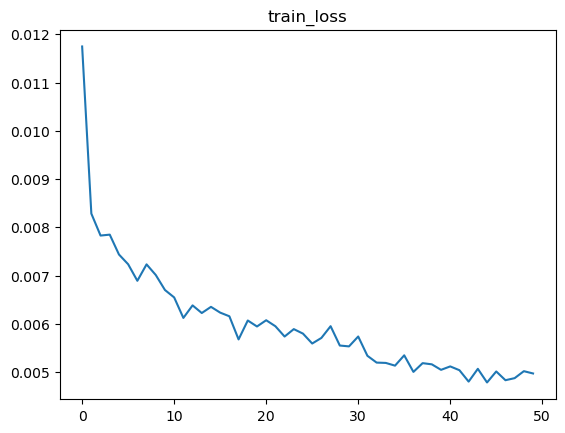

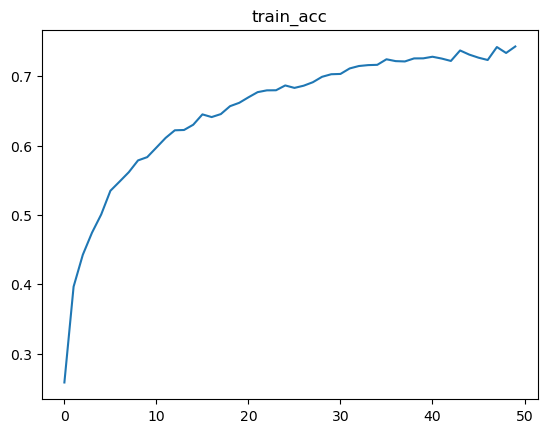

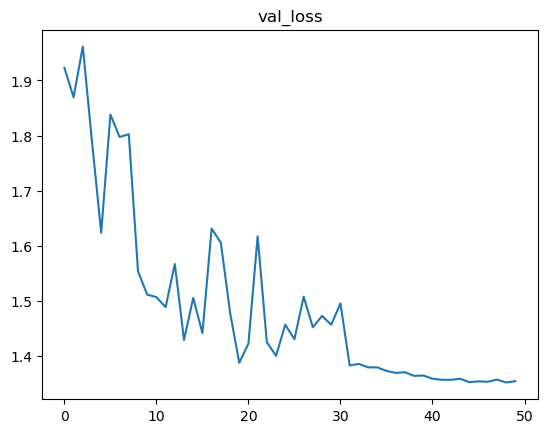

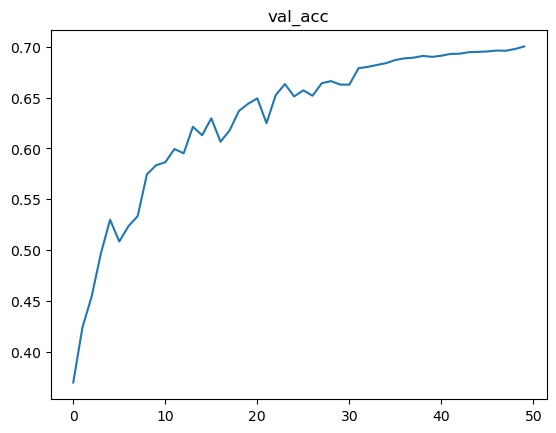

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.64it/s]

Experiment cifar+non_adv+dp+1024: Val accuracy: (0.001104230694770813, 0.74106)
Experiment cifar+non_adv+dp+1024: Training finished with epsilon 7.996553252047689


In [3]:
#vanilla dp
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
from experiment import Experiment
ex = Experiment_weighted(
    batch_size=1024, 
    epochs=50, 
    adv_attack=None, 
    adv_attack_mode=None, 
    adv_params=None, 
    device=device, 
    save_experiment=False, 
    verbose=True, 
    target_epsilon=8, 
    dataset='cifar', 
    adv_test=True, 
    max_batch_size=256)
ex.run()

In [4]:
ex._run_epoch(ex.test_loader, eval=True)

100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:46<00:00, 216.29it/s]


(1.3535696445426664, 0.7004)

cuda
Experiment cifar+non_adv+dp+1024: Loading data
Files already downloaded and verified
Files already downloaded and verified
Experiment cifar+non_adv+dp+1024: DP on
Experiment cifar+non_adv+dp+1024: Training started


223it [00:14, 15.05it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch   1/50, train loss: 1.25e-02, train acc: 0.249


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 52.36it/s]


Experiment cifar+non_adv+dp+1024: Epoch   1/50, val loss: 7.42e-03, val acc: 0.383


219it [00:14, 14.83it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch   2/50, train loss: 7.99e-03, train acc: 0.404


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 51.71it/s]


Experiment cifar+non_adv+dp+1024: Epoch   2/50, val loss: 6.95e-03, val acc: 0.431


219it [00:14, 14.66it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch   3/50, train loss: 7.74e-03, train acc: 0.455


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 50.93it/s]


Experiment cifar+non_adv+dp+1024: Epoch   3/50, val loss: 7.78e-03, val acc: 0.451


211it [00:14, 14.30it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch   4/50, train loss: 7.27e-03, train acc: 0.485


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 51.59it/s]


Experiment cifar+non_adv+dp+1024: Epoch   4/50, val loss: 7.26e-03, val acc: 0.480


219it [00:15, 14.56it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch   5/50, train loss: 7.57e-03, train acc: 0.504


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 51.30it/s]


Experiment cifar+non_adv+dp+1024: Epoch   5/50, val loss: 7.89e-03, val acc: 0.479


226it [00:15, 14.92it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch   6/50, train loss: 7.60e-03, train acc: 0.526


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 51.75it/s]


Experiment cifar+non_adv+dp+1024: Epoch   6/50, val loss: 6.38e-03, val acc: 0.537


213it [00:15, 14.19it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch   7/50, train loss: 6.99e-03, train acc: 0.541


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 51.69it/s]


Experiment cifar+non_adv+dp+1024: Epoch   7/50, val loss: 6.21e-03, val acc: 0.554


214it [00:14, 14.35it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch   8/50, train loss: 6.72e-03, train acc: 0.558


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 51.52it/s]


Experiment cifar+non_adv+dp+1024: Epoch   8/50, val loss: 7.04e-03, val acc: 0.539


214it [00:15, 14.22it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch   9/50, train loss: 7.02e-03, train acc: 0.559


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 51.12it/s]


Experiment cifar+non_adv+dp+1024: Epoch   9/50, val loss: 6.21e-03, val acc: 0.561


215it [00:15, 14.33it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch  10/50, train loss: 6.94e-03, train acc: 0.567


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 51.13it/s]


Experiment cifar+non_adv+dp+1024: Epoch  10/50, val loss: 6.64e-03, val acc: 0.551


214it [00:14, 14.27it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch  11/50, train loss: 6.49e-03, train acc: 0.588


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 51.14it/s]


Experiment cifar+non_adv+dp+1024: Epoch  11/50, val loss: 6.51e-03, val acc: 0.576


222it [00:15, 14.70it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch  12/50, train loss: 6.87e-03, train acc: 0.594


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 51.24it/s]


Experiment cifar+non_adv+dp+1024: Epoch  12/50, val loss: 6.34e-03, val acc: 0.579


212it [00:14, 14.17it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch  13/50, train loss: 6.24e-03, train acc: 0.605


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 51.88it/s]


Experiment cifar+non_adv+dp+1024: Epoch  13/50, val loss: 5.92e-03, val acc: 0.601


220it [00:15, 14.61it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch  14/50, train loss: 6.70e-03, train acc: 0.608


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 50.96it/s]


Experiment cifar+non_adv+dp+1024: Epoch  14/50, val loss: 6.54e-03, val acc: 0.589


217it [00:15, 14.41it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch  15/50, train loss: 6.32e-03, train acc: 0.620


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 51.23it/s]


Experiment cifar+non_adv+dp+1024: Epoch  15/50, val loss: 6.24e-03, val acc: 0.601


221it [00:15, 14.59it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch  16/50, train loss: 6.26e-03, train acc: 0.635


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 51.11it/s]


Experiment cifar+non_adv+dp+1024: Epoch  16/50, val loss: 6.05e-03, val acc: 0.614


214it [00:15, 14.22it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch  17/50, train loss: 6.16e-03, train acc: 0.633


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 49.84it/s]


Experiment cifar+non_adv+dp+1024: Epoch  17/50, val loss: 6.11e-03, val acc: 0.610


217it [00:15, 14.35it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch  18/50, train loss: 6.26e-03, train acc: 0.639


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 50.97it/s]


Experiment cifar+non_adv+dp+1024: Epoch  18/50, val loss: 6.78e-03, val acc: 0.600


212it [00:14, 14.15it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch  19/50, train loss: 6.02e-03, train acc: 0.640


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 51.35it/s]


Experiment cifar+non_adv+dp+1024: Epoch  19/50, val loss: 5.89e-03, val acc: 0.628


212it [00:14, 14.27it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch  20/50, train loss: 5.88e-03, train acc: 0.644


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 51.31it/s]


Experiment cifar+non_adv+dp+1024: Epoch  20/50, val loss: 6.33e-03, val acc: 0.609


224it [00:15, 14.64it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch  21/50, train loss: 6.39e-03, train acc: 0.651


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 50.50it/s]


Experiment cifar+non_adv+dp+1024: Epoch  21/50, val loss: 5.82e-03, val acc: 0.628


216it [00:15, 14.38it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch  22/50, train loss: 5.93e-03, train acc: 0.657


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 51.23it/s]


Experiment cifar+non_adv+dp+1024: Epoch  22/50, val loss: 5.72e-03, val acc: 0.641


226it [00:15, 14.84it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch  23/50, train loss: 6.28e-03, train acc: 0.667


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 50.80it/s]


Experiment cifar+non_adv+dp+1024: Epoch  23/50, val loss: 6.68e-03, val acc: 0.610


218it [00:15, 14.48it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch  24/50, train loss: 5.92e-03, train acc: 0.669


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 51.22it/s]


Experiment cifar+non_adv+dp+1024: Epoch  24/50, val loss: 6.30e-03, val acc: 0.625


213it [00:14, 14.24it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch  25/50, train loss: 5.71e-03, train acc: 0.668


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 50.58it/s]


Experiment cifar+non_adv+dp+1024: Epoch  25/50, val loss: 6.05e-03, val acc: 0.638


227it [00:15, 14.94it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch  26/50, train loss: 6.23e-03, train acc: 0.677


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 49.86it/s]


Experiment cifar+non_adv+dp+1024: Epoch  26/50, val loss: 5.89e-03, val acc: 0.649


220it [00:15, 14.54it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch  27/50, train loss: 5.90e-03, train acc: 0.678


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 50.70it/s]


Experiment cifar+non_adv+dp+1024: Epoch  27/50, val loss: 5.95e-03, val acc: 0.643


221it [00:15, 14.65it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch  28/50, train loss: 5.95e-03, train acc: 0.682


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 50.00it/s]


Experiment cifar+non_adv+dp+1024: Epoch  28/50, val loss: 5.80e-03, val acc: 0.656


213it [00:15, 14.15it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch  29/50, train loss: 5.53e-03, train acc: 0.683


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 50.13it/s]


Experiment cifar+non_adv+dp+1024: Epoch  29/50, val loss: 6.07e-03, val acc: 0.648


217it [00:15, 14.44it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch  30/50, train loss: 5.75e-03, train acc: 0.684


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 50.48it/s]


Experiment cifar+non_adv+dp+1024: Epoch  30/50, val loss: 5.88e-03, val acc: 0.658


220it [00:15, 14.49it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch  31/50, train loss: 5.99e-03, train acc: 0.690


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 50.58it/s]


Experiment cifar+non_adv+dp+1024: Epoch  31/50, val loss: 6.03e-03, val acc: 0.650


221it [00:15, 14.47it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch  32/50, train loss: 5.88e-03, train acc: 0.694


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 50.51it/s]


Experiment cifar+non_adv+dp+1024: Epoch  32/50, val loss: 6.30e-03, val acc: 0.648


218it [00:15, 14.45it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch  33/50, train loss: 5.54e-03, train acc: 0.697


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 51.42it/s]


Experiment cifar+non_adv+dp+1024: Epoch  33/50, val loss: 5.85e-03, val acc: 0.662


218it [00:15, 14.39it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch  34/50, train loss: 5.77e-03, train acc: 0.696


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 50.61it/s]


Experiment cifar+non_adv+dp+1024: Epoch  34/50, val loss: 6.61e-03, val acc: 0.643


216it [00:15, 14.39it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch  35/50, train loss: 5.63e-03, train acc: 0.696


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 51.32it/s]


Experiment cifar+non_adv+dp+1024: Epoch  35/50, val loss: 6.34e-03, val acc: 0.656


215it [00:15, 14.31it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch  36/50, train loss: 5.77e-03, train acc: 0.691


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 51.28it/s]


Experiment cifar+non_adv+dp+1024: Epoch  36/50, val loss: 5.85e-03, val acc: 0.673


223it [00:15, 14.74it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch  37/50, train loss: 5.75e-03, train acc: 0.706


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 50.01it/s]


Experiment cifar+non_adv+dp+1024: Epoch  37/50, val loss: 5.88e-03, val acc: 0.672


215it [00:14, 14.37it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch  38/50, train loss: 5.49e-03, train acc: 0.703


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 51.05it/s]


Experiment cifar+non_adv+dp+1024: Epoch  38/50, val loss: 5.95e-03, val acc: 0.667


218it [00:15, 14.38it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch  39/50, train loss: 5.77e-03, train acc: 0.702


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 49.66it/s]


Experiment cifar+non_adv+dp+1024: Epoch  39/50, val loss: 6.15e-03, val acc: 0.669


219it [00:15, 14.51it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch  40/50, train loss: 5.67e-03, train acc: 0.704


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 49.94it/s]


Experiment cifar+non_adv+dp+1024: Epoch  40/50, val loss: 5.87e-03, val acc: 0.673


223it [00:15, 14.63it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch  41/50, train loss: 5.72e-03, train acc: 0.717


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 49.47it/s]


Experiment cifar+non_adv+dp+1024: Epoch  41/50, val loss: 6.23e-03, val acc: 0.669


216it [00:15, 14.33it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch  42/50, train loss: 5.54e-03, train acc: 0.709


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 51.08it/s]


Experiment cifar+non_adv+dp+1024: Epoch  42/50, val loss: 5.92e-03, val acc: 0.679


222it [00:15, 14.53it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch  43/50, train loss: 5.59e-03, train acc: 0.720


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 50.26it/s]


Experiment cifar+non_adv+dp+1024: Epoch  43/50, val loss: 5.89e-03, val acc: 0.683


223it [00:15, 14.70it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch  44/50, train loss: 5.68e-03, train acc: 0.716


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 50.83it/s]


Experiment cifar+non_adv+dp+1024: Epoch  44/50, val loss: 6.36e-03, val acc: 0.671


217it [00:15, 14.43it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch  45/50, train loss: 5.51e-03, train acc: 0.712


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 50.47it/s]


Experiment cifar+non_adv+dp+1024: Epoch  45/50, val loss: 6.03e-03, val acc: 0.677


216it [00:14, 14.45it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch  46/50, train loss: 5.44e-03, train acc: 0.712


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 49.88it/s]


Experiment cifar+non_adv+dp+1024: Epoch  46/50, val loss: 5.81e-03, val acc: 0.684


216it [00:15, 14.31it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch  47/50, train loss: 5.46e-03, train acc: 0.717


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 49.96it/s]


Experiment cifar+non_adv+dp+1024: Epoch  47/50, val loss: 5.90e-03, val acc: 0.679


221it [00:15, 14.53it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch  48/50, train loss: 5.54e-03, train acc: 0.726


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 51.62it/s]


Experiment cifar+non_adv+dp+1024: Epoch  48/50, val loss: 5.93e-03, val acc: 0.683


222it [00:15, 14.73it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch  49/50, train loss: 5.60e-03, train acc: 0.720


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 50.34it/s]


Experiment cifar+non_adv+dp+1024: Epoch  49/50, val loss: 5.81e-03, val acc: 0.693


220it [00:15, 14.58it/s]                                                                                                              


Experiment cifar+non_adv+dp+1024: Epoch  50/50, train loss: 5.62e-03, train acc: 0.721


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 50.43it/s]


Experiment cifar+non_adv+dp+1024: Epoch  50/50, val loss: 6.17e-03, val acc: 0.679


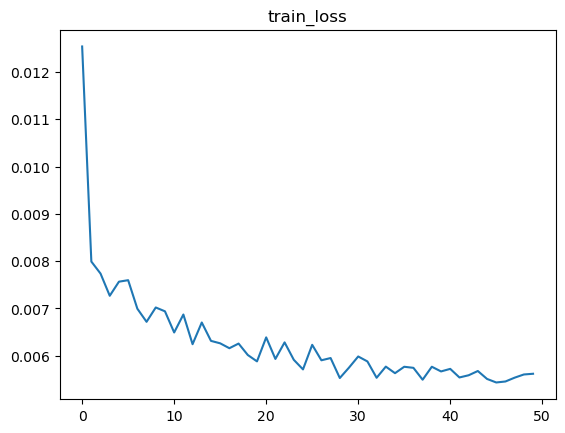

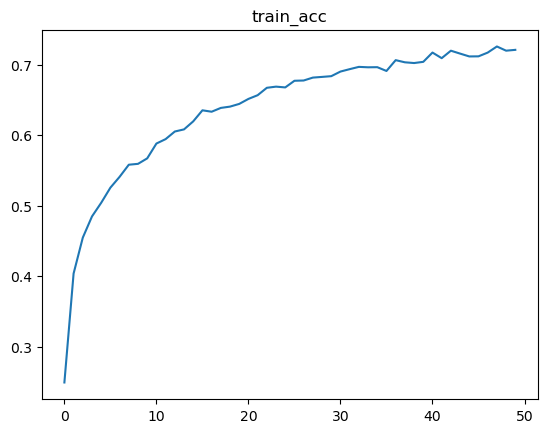

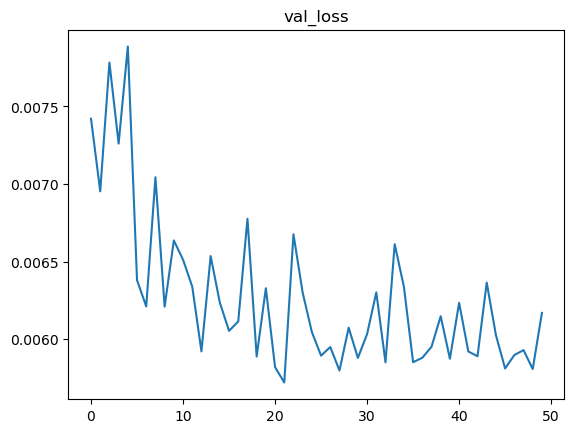

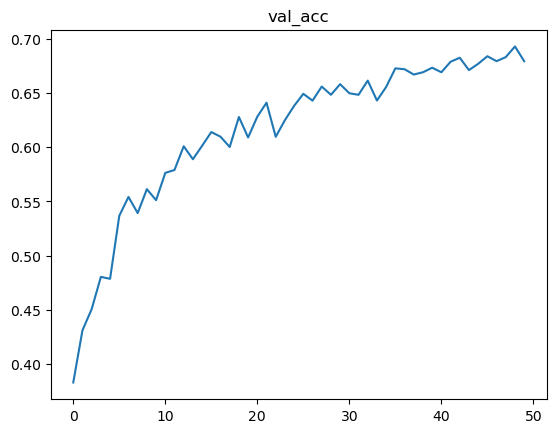

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.45it/s]


Experiment cifar+non_adv+dp+1024: Val accuracy: (0.0012703116607666015, 0.71614)
Experiment cifar+non_adv+dp+1024: Training finished with epsilon 7.492937438858805


In [29]:
#vanilla dp
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# print(device)
# from experiment import Experiment
# ex = Experiment_weighted(
#     batch_size=1024, 
#     epochs=50, 
#     adv_attack=None, 
#     adv_attack_mode=None, 
#     adv_params=None, 
#     device=device, 
#     save_experiment=False, 
#     verbose=True, 
#     target_epsilon=7.5, 
#     dataset='cifar', 
#     adv_test=True, 
#     max_batch_size=256)
# ex.run()

In [5]:
# ex._run_epoch(ex.test_loader, eval=True)

100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:47<00:00, 212.50it/s]


(1.5687125394522041, 0.6467)

cuda
Experiment cifar+adv-batch+dp+1024: Loading data
Files already downloaded and verified
Files already downloaded and verified
Experiment cifar+adv-batch+dp+1024: DP on
Experiment cifar+adv-batch+dp+1024: Training started


221it [00:19, 11.48it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   1/50, train loss: 1.39e-02, train acc: 0.054


218it [00:19, 11.25it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   2/50, train loss: 1.07e-02, train acc: 0.130


219it [00:19, 11.16it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   3/50, train loss: 1.03e-02, train acc: 0.164


213it [00:19, 10.90it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   4/50, train loss: 9.78e-03, train acc: 0.179


220it [00:19, 11.23it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   5/50, train loss: 9.97e-03, train acc: 0.191


222it [00:19, 11.31it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   6/50, train loss: 9.98e-03, train acc: 0.201


219it [00:19, 11.26it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   7/50, train loss: 9.76e-03, train acc: 0.207


219it [00:19, 11.29it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   8/50, train loss: 9.72e-03, train acc: 0.210


219it [00:19, 11.21it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   9/50, train loss: 9.67e-03, train acc: 0.214


224it [00:19, 11.43it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  10/50, train loss: 9.83e-03, train acc: 0.227


217it [00:19, 11.16it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  11/50, train loss: 9.46e-03, train acc: 0.232


223it [00:19, 11.41it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  12/50, train loss: 9.75e-03, train acc: 0.232


219it [00:19, 11.29it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  13/50, train loss: 9.48e-03, train acc: 0.233


218it [00:19, 11.15it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  14/50, train loss: 9.41e-03, train acc: 0.237


221it [00:19, 11.38it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  15/50, train loss: 9.54e-03, train acc: 0.238


216it [00:19, 11.12it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  16/50, train loss: 9.31e-03, train acc: 0.245


216it [00:19, 11.15it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  17/50, train loss: 9.24e-03, train acc: 0.249


223it [00:19, 11.45it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  18/50, train loss: 9.63e-03, train acc: 0.255


221it [00:19, 11.28it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  19/50, train loss: 9.55e-03, train acc: 0.256


214it [00:19, 11.05it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  20/50, train loss: 9.25e-03, train acc: 0.254


216it [00:19, 11.13it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  21/50, train loss: 9.29e-03, train acc: 0.259


214it [00:19, 11.09it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  22/50, train loss: 9.25e-03, train acc: 0.252


219it [00:19, 11.25it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  23/50, train loss: 9.43e-03, train acc: 0.258


216it [00:19, 11.12it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  24/50, train loss: 9.20e-03, train acc: 0.261


219it [00:19, 11.32it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  25/50, train loss: 9.29e-03, train acc: 0.262


219it [00:19, 11.29it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  26/50, train loss: 9.28e-03, train acc: 0.270


217it [00:19, 11.18it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  27/50, train loss: 9.25e-03, train acc: 0.269


217it [00:19, 11.16it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  28/50, train loss: 9.28e-03, train acc: 0.267


219it [00:19, 11.28it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  29/50, train loss: 9.36e-03, train acc: 0.268


215it [00:19, 11.14it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  30/50, train loss: 9.12e-03, train acc: 0.266


218it [00:19, 11.20it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  31/50, train loss: 9.24e-03, train acc: 0.270


222it [00:19, 11.40it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  32/50, train loss: 9.51e-03, train acc: 0.272


213it [00:19, 11.04it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  33/50, train loss: 9.13e-03, train acc: 0.271


218it [00:19, 11.10it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  34/50, train loss: 9.40e-03, train acc: 0.267


215it [00:19, 11.12it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  35/50, train loss: 9.20e-03, train acc: 0.267


214it [00:19, 11.08it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  36/50, train loss: 9.11e-03, train acc: 0.268


214it [00:19, 11.03it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  37/50, train loss: 9.09e-03, train acc: 0.275


219it [00:19, 11.26it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  38/50, train loss: 9.35e-03, train acc: 0.277


224it [00:19, 11.54it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  39/50, train loss: 9.59e-03, train acc: 0.276


215it [00:19, 11.11it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  40/50, train loss: 9.13e-03, train acc: 0.275


219it [00:19, 11.30it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  41/50, train loss: 9.32e-03, train acc: 0.276


220it [00:19, 11.22it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  42/50, train loss: 9.41e-03, train acc: 0.275


219it [00:19, 11.23it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  43/50, train loss: 9.32e-03, train acc: 0.277


217it [00:19, 11.18it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  44/50, train loss: 9.19e-03, train acc: 0.277


214it [00:19, 11.13it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  45/50, train loss: 9.11e-03, train acc: 0.276


216it [00:19, 11.16it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  46/50, train loss: 9.21e-03, train acc: 0.280


215it [00:19, 11.14it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  47/50, train loss: 9.16e-03, train acc: 0.282


224it [00:19, 11.45it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  48/50, train loss: 9.52e-03, train acc: 0.286


219it [00:19, 11.30it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  49/50, train loss: 9.32e-03, train acc: 0.284


222it [00:19, 11.34it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  50/50, train loss: 9.44e-03, train acc: 0.283


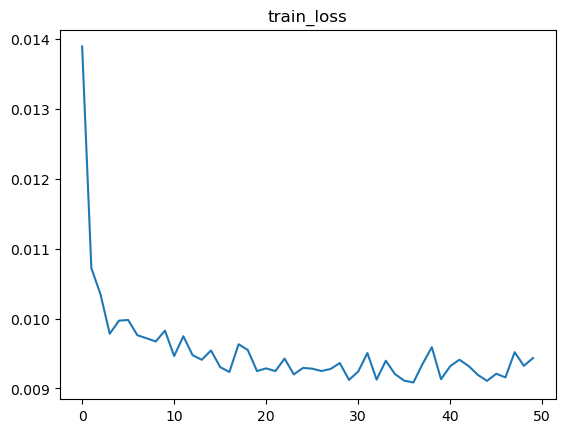

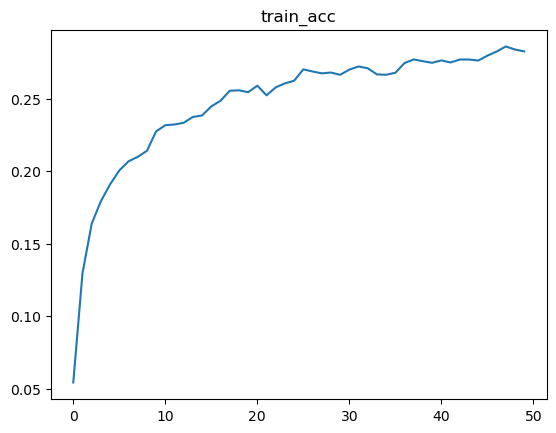

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.43it/s]

Experiment cifar+adv-batch+dp+1024: Val accuracy: (0.0020227900695800782, 0.34824)
Experiment cifar+adv-batch+dp+1024: Training finished with epsilon 0.9910639942617069


In [24]:
#vanilla dp + adv
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# print(device)
# from experiment import Experiment
# ex = Experiment(
#     batch_size=1024, 
#     epochs=50, 
#     adv_attack=torchattacks.FFGSM, 
#     adv_attack_mode='batch', 
#     adv_params={'eps':8/255}, 
#     dp=True, 
#     device=device, 
#     save_experiment=False, 
#     verbose=True, 
#     target_epsilon=2.5, 
#     dataset='cifar', 
#     adv_test=True, 
#     max_batch_size=256)

# ex.run()

In [25]:
# ex._run_epoch(ex.test_loader, eval=True)

100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 427.57it/s]


(2.0327322209653316, 0.3624)

cuda
Experiment cifar+adv-batch+dp+1024: Loading data
Files already downloaded and verified
Files already downloaded and verified
Experiment cifar+adv-batch+dp+1024: DP on
Experiment cifar+adv-batch+dp+1024: Training started


218it [00:37,  5.76it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   1/50, train loss: 1.31e-02, train acc: 0.053


216it [00:38,  5.62it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   2/50, train loss: 1.06e-02, train acc: 0.128


216it [00:38,  5.64it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   3/50, train loss: 1.01e-02, train acc: 0.159


219it [00:38,  5.74it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   4/50, train loss: 9.90e-03, train acc: 0.186


221it [00:38,  5.74it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   5/50, train loss: 9.85e-03, train acc: 0.203


215it [00:37,  5.66it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   6/50, train loss: 9.42e-03, train acc: 0.214


217it [00:38,  5.71it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   7/50, train loss: 9.41e-03, train acc: 0.225


219it [00:37,  5.77it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   8/50, train loss: 9.50e-03, train acc: 0.232


221it [00:38,  5.79it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   9/50, train loss: 9.55e-03, train acc: 0.241


219it [00:38,  5.73it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  10/50, train loss: 9.39e-03, train acc: 0.249


218it [00:38,  5.71it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  11/50, train loss: 9.28e-03, train acc: 0.251


217it [00:38,  5.67it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  12/50, train loss: 9.24e-03, train acc: 0.251


220it [00:38,  5.76it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  13/50, train loss: 9.33e-03, train acc: 0.259


215it [00:37,  5.69it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  14/50, train loss: 9.03e-03, train acc: 0.260


218it [00:38,  5.72it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  15/50, train loss: 9.18e-03, train acc: 0.266


218it [00:38,  5.72it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  16/50, train loss: 9.12e-03, train acc: 0.276


220it [00:38,  5.78it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  17/50, train loss: 9.19e-03, train acc: 0.280


218it [00:38,  5.74it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  18/50, train loss: 9.08e-03, train acc: 0.287


220it [00:38,  5.75it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  19/50, train loss: 9.26e-03, train acc: 0.285


219it [00:38,  5.75it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  20/50, train loss: 9.19e-03, train acc: 0.284


220it [00:38,  5.77it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  21/50, train loss: 9.16e-03, train acc: 0.288


221it [00:38,  5.78it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  22/50, train loss: 9.22e-03, train acc: 0.292


215it [00:37,  5.69it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  23/50, train loss: 8.89e-03, train acc: 0.294


214it [00:37,  5.67it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  24/50, train loss: 8.86e-03, train acc: 0.290


214it [00:37,  5.66it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  25/50, train loss: 8.82e-03, train acc: 0.299


221it [00:38,  5.79it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  26/50, train loss: 9.07e-03, train acc: 0.306


217it [00:37,  5.73it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  27/50, train loss: 8.84e-03, train acc: 0.307


220it [00:38,  5.78it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  28/50, train loss: 9.07e-03, train acc: 0.307


223it [00:38,  5.84it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  29/50, train loss: 9.16e-03, train acc: 0.306


216it [00:37,  5.68it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  30/50, train loss: 8.87e-03, train acc: 0.306


216it [00:38,  5.67it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  31/50, train loss: 8.87e-03, train acc: 0.307


217it [00:37,  5.72it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  32/50, train loss: 8.94e-03, train acc: 0.304


219it [00:38,  5.74it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  33/50, train loss: 9.05e-03, train acc: 0.308


216it [00:37,  5.70it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  34/50, train loss: 8.97e-03, train acc: 0.307


213it [00:37,  5.62it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  35/50, train loss: 8.84e-03, train acc: 0.307


219it [00:38,  5.75it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  36/50, train loss: 9.07e-03, train acc: 0.309


221it [00:38,  5.74it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  37/50, train loss: 9.08e-03, train acc: 0.315


222it [00:38,  5.78it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  38/50, train loss: 9.14e-03, train acc: 0.316


222it [00:38,  5.83it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  39/50, train loss: 9.13e-03, train acc: 0.315


218it [00:37,  5.75it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  40/50, train loss: 8.97e-03, train acc: 0.320


217it [00:38,  5.70it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  41/50, train loss: 8.93e-03, train acc: 0.318


216it [00:38,  5.67it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  42/50, train loss: 8.91e-03, train acc: 0.317


221it [00:38,  5.76it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  43/50, train loss: 9.05e-03, train acc: 0.319


215it [00:37,  5.66it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  44/50, train loss: 8.77e-03, train acc: 0.321


209it [00:37,  5.53it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  45/50, train loss: 8.51e-03, train acc: 0.321


215it [00:37,  5.68it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  46/50, train loss: 8.85e-03, train acc: 0.317


217it [00:38,  5.69it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  47/50, train loss: 8.92e-03, train acc: 0.317


222it [00:38,  5.83it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  48/50, train loss: 9.06e-03, train acc: 0.320


221it [00:38,  5.80it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  49/50, train loss: 9.04e-03, train acc: 0.318


216it [00:37,  5.70it/s]                                                                                                          

Experiment cifar+adv-batch+dp+1024: Epoch  50/50, train loss: 8.81e-03, train acc: 0.324


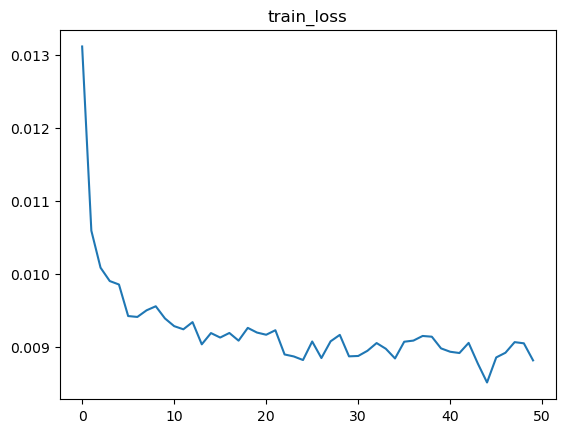

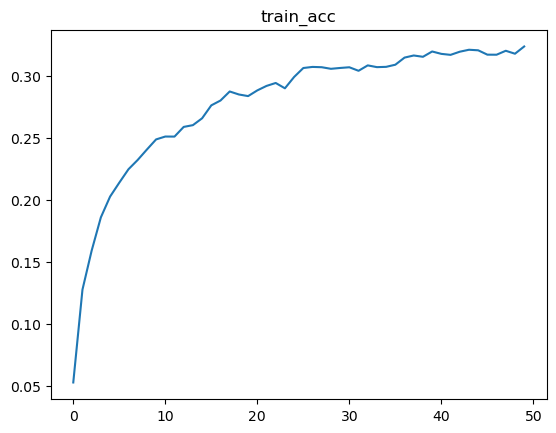

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 14.39it/s]

Experiment cifar+adv-batch+dp+1024: Val accuracy: (0.0019835600423812865, 0.36708)
Experiment cifar+adv-batch+dp+1024: Training finished with epsilon 0.9910639942617069


In [26]:
# #vanilla dp + adv
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# print(device)
# from experiment import Experiment
# ex = Experiment(
#     batch_size=1024, 
#     epochs=50, 
#     adv_attack=torchattacks.PGD, 
#     adv_attack_mode='batch', 
#     adv_params={'eps':8/255, 'alpha':1/255, 'steps':5, 'random_start':True}, 
#     dp=True, 
#     device=device, 
#     save_experiment=False, 
#     verbose=True, 
#     target_epsilon=2.5, 
#     dataset='cifar', 
#     adv_test=True, 
#     max_batch_size=256)

# ex.run()

In [27]:
# ex._run_epoch(ex.test_loader, eval=True)

100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.56it/s]


(2.0110794931642455, 0.3655)

Experiment cifar+adv-batch+dp+1024: Loading data
Files already downloaded and verified
Files already downloaded and verified


/home/anna/miniconda3/envs/ap/lib/python3.10/site-packages/opacus/privacy_engine.py:141: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/home/anna/miniconda3/envs/ap/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


Experiment cifar+adv-batch+dp+1024: DP on
Experiment cifar+adv-batch+dp+1024: Training started


  0%|                                                                                                         | 0/195 [00:00<?, ?it/s]/home/anna/miniconda3/envs/ap/lib/python3.10/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
215it [00:32,  6.53it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch   1/50, train loss: 1.20e-02, train acc: 0.248


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:05<00:00, 79.77it/s]


Experiment cifar+adv-batch+dp+1024: Epoch   1/50, val loss: 2.01e+00, val acc: 0.323


218it [00:31,  6.83it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch   2/50, train loss: 8.29e-03, train acc: 0.375


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:06<00:00, 78.79it/s]


Experiment cifar+adv-batch+dp+1024: Epoch   2/50, val loss: 1.74e+00, val acc: 0.424


214it [00:31,  6.75it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch   3/50, train loss: 7.57e-03, train acc: 0.425


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:56<00:00, 85.57it/s]


Experiment cifar+adv-batch+dp+1024: Epoch   3/50, val loss: 2.01e+00, val acc: 0.441


218it [00:31,  6.82it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch   4/50, train loss: 7.80e-03, train acc: 0.447


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:06<00:00, 78.89it/s]


Experiment cifar+adv-batch+dp+1024: Epoch   4/50, val loss: 1.75e+00, val acc: 0.459


215it [00:31,  6.80it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch   5/50, train loss: 7.19e-03, train acc: 0.477


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:06<00:00, 78.78it/s]


Experiment cifar+adv-batch+dp+1024: Epoch   5/50, val loss: 1.59e+00, val acc: 0.494


219it [00:32,  6.84it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch   6/50, train loss: 7.28e-03, train acc: 0.497


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:07<00:00, 78.57it/s]


Experiment cifar+adv-batch+dp+1024: Epoch   6/50, val loss: 1.69e+00, val acc: 0.498


214it [00:31,  6.76it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch   7/50, train loss: 6.90e-03, train acc: 0.511


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:07<00:00, 78.60it/s]


Experiment cifar+adv-batch+dp+1024: Epoch   7/50, val loss: 1.58e+00, val acc: 0.512


222it [00:32,  6.93it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch   8/50, train loss: 6.93e-03, train acc: 0.531


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:07<00:00, 78.28it/s]


Experiment cifar+adv-batch+dp+1024: Epoch   8/50, val loss: 1.62e+00, val acc: 0.525


224it [00:32,  6.97it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch   9/50, train loss: 6.94e-03, train acc: 0.543


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:06<00:00, 78.83it/s]


Experiment cifar+adv-batch+dp+1024: Epoch   9/50, val loss: 1.81e+00, val acc: 0.511


218it [00:31,  6.85it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch  10/50, train loss: 6.61e-03, train acc: 0.549


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:04<00:00, 80.10it/s]


Experiment cifar+adv-batch+dp+1024: Epoch  10/50, val loss: 1.47e+00, val acc: 0.556


218it [00:31,  6.84it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch  11/50, train loss: 6.38e-03, train acc: 0.566


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:07<00:00, 78.13it/s]


Experiment cifar+adv-batch+dp+1024: Epoch  11/50, val loss: 1.46e+00, val acc: 0.562


213it [00:31,  6.71it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch  12/50, train loss: 6.06e-03, train acc: 0.576


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:06<00:00, 79.06it/s]


Experiment cifar+adv-batch+dp+1024: Epoch  12/50, val loss: 1.42e+00, val acc: 0.577


221it [00:32,  6.88it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch  13/50, train loss: 6.31e-03, train acc: 0.587


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:06<00:00, 79.03it/s]


Experiment cifar+adv-batch+dp+1024: Epoch  13/50, val loss: 1.50e+00, val acc: 0.559


216it [00:31,  6.77it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch  14/50, train loss: 6.18e-03, train acc: 0.585


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:06<00:00, 78.85it/s]


Experiment cifar+adv-batch+dp+1024: Epoch  14/50, val loss: 1.40e+00, val acc: 0.588


220it [00:32,  6.87it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch  15/50, train loss: 6.25e-03, train acc: 0.595


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:06<00:00, 78.98it/s]


Experiment cifar+adv-batch+dp+1024: Epoch  15/50, val loss: 1.49e+00, val acc: 0.572


220it [00:32,  6.84it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch  16/50, train loss: 6.20e-03, train acc: 0.606


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:06<00:00, 78.77it/s]


Experiment cifar+adv-batch+dp+1024: Epoch  16/50, val loss: 1.49e+00, val acc: 0.587


217it [00:31,  6.82it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch  17/50, train loss: 5.83e-03, train acc: 0.611


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:06<00:00, 78.79it/s]


Experiment cifar+adv-batch+dp+1024: Epoch  17/50, val loss: 1.50e+00, val acc: 0.585


207it [00:31,  6.58it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch  18/50, train loss: 5.49e-03, train acc: 0.613


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:00<00:00, 82.93it/s]


Experiment cifar+adv-batch+dp+1024: Epoch  18/50, val loss: 1.44e+00, val acc: 0.600


220it [00:32,  6.87it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch  19/50, train loss: 5.88e-03, train acc: 0.622


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:08<00:00, 77.93it/s]


Experiment cifar+adv-batch+dp+1024: Epoch  19/50, val loss: 1.46e+00, val acc: 0.591


218it [00:32,  6.78it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch  20/50, train loss: 5.69e-03, train acc: 0.630


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:05<00:00, 79.73it/s]


Experiment cifar+adv-batch+dp+1024: Epoch  20/50, val loss: 1.33e+00, val acc: 0.615


226it [00:32,  7.01it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch  21/50, train loss: 5.79e-03, train acc: 0.640


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:06<00:00, 79.00it/s]


Experiment cifar+adv-batch+dp+1024: Epoch  21/50, val loss: 1.36e+00, val acc: 0.613


224it [00:32,  6.94it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch  22/50, train loss: 5.88e-03, train acc: 0.636


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:06<00:00, 79.14it/s]


Experiment cifar+adv-batch+dp+1024: Epoch  22/50, val loss: 1.36e+00, val acc: 0.617


220it [00:32,  6.85it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch  23/50, train loss: 5.52e-03, train acc: 0.645


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:06<00:00, 79.26it/s]


Experiment cifar+adv-batch+dp+1024: Epoch  23/50, val loss: 1.30e+00, val acc: 0.627


221it [00:32,  6.89it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch  24/50, train loss: 5.54e-03, train acc: 0.648


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:08<00:00, 78.04it/s]


Experiment cifar+adv-batch+dp+1024: Epoch  24/50, val loss: 1.30e+00, val acc: 0.629


221it [00:32,  6.90it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch  25/50, train loss: 5.56e-03, train acc: 0.652


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:07<00:00, 78.64it/s]


Experiment cifar+adv-batch+dp+1024: Epoch  25/50, val loss: 1.29e+00, val acc: 0.636


215it [00:31,  6.74it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch  26/50, train loss: 5.23e-03, train acc: 0.654


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:04<00:00, 80.52it/s]


Experiment cifar+adv-batch+dp+1024: Epoch  26/50, val loss: 1.28e+00, val acc: 0.631


221it [00:31,  6.93it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch  27/50, train loss: 5.46e-03, train acc: 0.648


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:06<00:00, 79.22it/s]


Experiment cifar+adv-batch+dp+1024: Epoch  27/50, val loss: 1.28e+00, val acc: 0.640


222it [00:32,  6.88it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch  28/50, train loss: 5.51e-03, train acc: 0.659


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:07<00:00, 78.13it/s]


Experiment cifar+adv-batch+dp+1024: Epoch  28/50, val loss: 1.30e+00, val acc: 0.637


217it [00:31,  6.79it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch  29/50, train loss: 5.08e-03, train acc: 0.671


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:06<00:00, 79.20it/s]


Experiment cifar+adv-batch+dp+1024: Epoch  29/50, val loss: 1.29e+00, val acc: 0.647


217it [00:32,  6.76it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch  30/50, train loss: 5.21e-03, train acc: 0.667


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:07<00:00, 78.54it/s]


Experiment cifar+adv-batch+dp+1024: Epoch  30/50, val loss: 1.30e+00, val acc: 0.643


220it [00:32,  6.86it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch  31/50, train loss: 5.41e-03, train acc: 0.664


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:06<00:00, 78.95it/s]


Experiment cifar+adv-batch+dp+1024: Epoch  31/50, val loss: 1.25e+00, val acc: 0.652


219it [00:31,  6.87it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch  32/50, train loss: 5.29e-03, train acc: 0.666


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:04<00:00, 80.64it/s]


Experiment cifar+adv-batch+dp+1024: Epoch  32/50, val loss: 1.32e+00, val acc: 0.641


218it [00:31,  6.84it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch  33/50, train loss: 5.09e-03, train acc: 0.672


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:06<00:00, 78.75it/s]


Experiment cifar+adv-batch+dp+1024: Epoch  33/50, val loss: 1.27e+00, val acc: 0.651


219it [00:31,  6.87it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch  34/50, train loss: 5.16e-03, train acc: 0.672


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:03<00:00, 81.17it/s]


Experiment cifar+adv-batch+dp+1024: Epoch  34/50, val loss: 1.29e+00, val acc: 0.646


217it [00:31,  6.81it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch  35/50, train loss: 5.09e-03, train acc: 0.673


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:05<00:00, 79.43it/s]


Experiment cifar+adv-batch+dp+1024: Epoch  35/50, val loss: 1.25e+00, val acc: 0.655


225it [00:32,  7.00it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch  36/50, train loss: 5.21e-03, train acc: 0.681


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:02<00:00, 81.91it/s]


Experiment cifar+adv-batch+dp+1024: Epoch  36/50, val loss: 1.30e+00, val acc: 0.647


214it [00:31,  6.73it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch  37/50, train loss: 4.92e-03, train acc: 0.679


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:06<00:00, 79.13it/s]


Experiment cifar+adv-batch+dp+1024: Epoch  37/50, val loss: 1.26e+00, val acc: 0.658


220it [00:31,  6.90it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch  38/50, train loss: 5.10e-03, train acc: 0.681


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:06<00:00, 79.10it/s]


Experiment cifar+adv-batch+dp+1024: Epoch  38/50, val loss: 1.23e+00, val acc: 0.660


218it [00:31,  6.82it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch  39/50, train loss: 5.13e-03, train acc: 0.677


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:07<00:00, 78.39it/s]


Experiment cifar+adv-batch+dp+1024: Epoch  39/50, val loss: 1.22e+00, val acc: 0.665


219it [00:31,  6.90it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch  40/50, train loss: 4.88e-03, train acc: 0.686


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:04<00:00, 80.11it/s]


Experiment cifar+adv-batch+dp+1024: Epoch  40/50, val loss: 1.20e+00, val acc: 0.667


222it [00:31,  6.95it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch  41/50, train loss: 5.10e-03, train acc: 0.685


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:07<00:00, 78.63it/s]


Experiment cifar+adv-batch+dp+1024: Epoch  41/50, val loss: 1.27e+00, val acc: 0.653


219it [00:31,  6.90it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch  42/50, train loss: 4.95e-03, train acc: 0.683


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:06<00:00, 79.22it/s]


Experiment cifar+adv-batch+dp+1024: Epoch  42/50, val loss: 1.20e+00, val acc: 0.673


208it [00:31,  6.60it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch  43/50, train loss: 4.63e-03, train acc: 0.686


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:06<00:00, 79.05it/s]


Experiment cifar+adv-batch+dp+1024: Epoch  43/50, val loss: 1.23e+00, val acc: 0.671


222it [00:32,  6.89it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch  44/50, train loss: 5.00e-03, train acc: 0.698


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:05<00:00, 79.68it/s]


Experiment cifar+adv-batch+dp+1024: Epoch  44/50, val loss: 1.19e+00, val acc: 0.674


213it [00:31,  6.74it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch  45/50, train loss: 4.68e-03, train acc: 0.695


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:05<00:00, 79.44it/s]


Experiment cifar+adv-batch+dp+1024: Epoch  45/50, val loss: 1.19e+00, val acc: 0.671


218it [00:31,  6.86it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch  46/50, train loss: 4.89e-03, train acc: 0.689


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:07<00:00, 78.43it/s]


Experiment cifar+adv-batch+dp+1024: Epoch  46/50, val loss: 1.51e+00, val acc: 0.632


210it [00:31,  6.70it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch  47/50, train loss: 4.75e-03, train acc: 0.686


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:06<00:00, 78.90it/s]


Experiment cifar+adv-batch+dp+1024: Epoch  47/50, val loss: 1.20e+00, val acc: 0.673


222it [00:32,  6.88it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch  48/50, train loss: 4.76e-03, train acc: 0.706


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:08<00:00, 78.00it/s]


Experiment cifar+adv-batch+dp+1024: Epoch  48/50, val loss: 1.21e+00, val acc: 0.669


220it [00:32,  6.84it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch  49/50, train loss: 4.77e-03, train acc: 0.702


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:06<00:00, 79.16it/s]


Experiment cifar+adv-batch+dp+1024: Epoch  49/50, val loss: 1.16e+00, val acc: 0.682


222it [00:32,  6.92it/s]                                                                                                              


Experiment cifar+adv-batch+dp+1024: Epoch  50/50, train loss: 4.74e-03, train acc: 0.710


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:05<00:00, 79.74it/s]


Experiment cifar+adv-batch+dp+1024: Epoch  50/50, val loss: 1.21e+00, val acc: 0.676


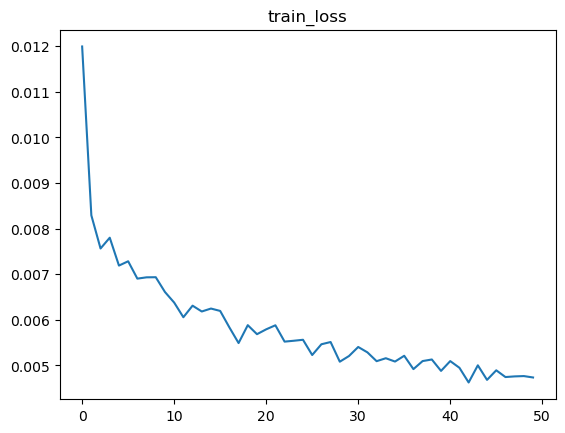

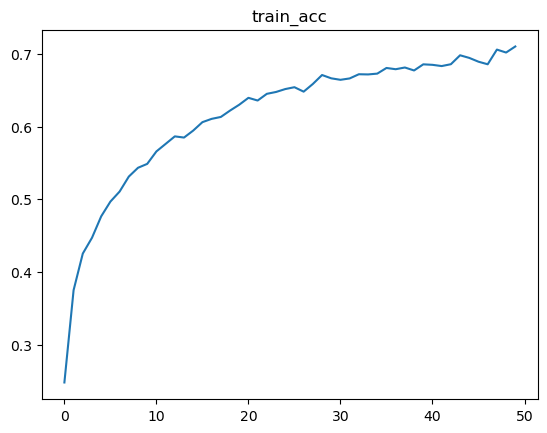

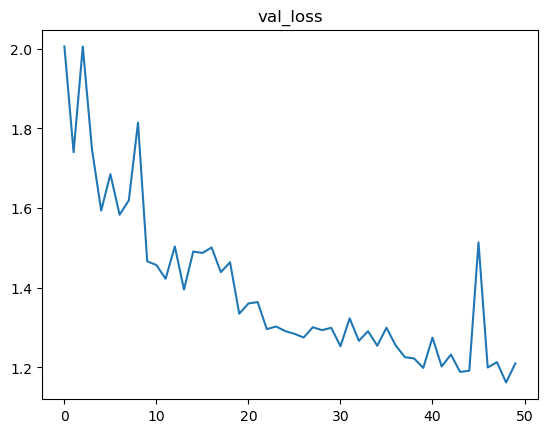

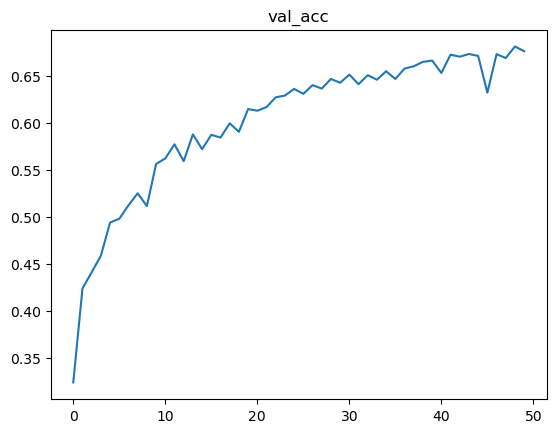

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.35it/s]

Experiment cifar+adv-batch+dp+1024: Val accuracy: (0.001062246209383011, 0.70824)
Experiment cifar+adv-batch+dp+1024: Training finished with epsilon 7.996553252047689


In [5]:
#90 clean - 10 adv
torch.cuda.empty_cache() 
ex = Experiment_weighted(
    batch_size=1024, 
    epochs=50, 
    adv_attack=torchattacks.FFGSM, 
    adv_attack_mode='batch', 
    adv_params={'eps':8/255}, 
    dp=True, 
    device=device, 
    save_experiment=False, 
    verbose=True, 
    target_epsilon=8, 
    dataset='cifar', 
    adv_test=True, 
    max_batch_size=256)

ex.run()

In [6]:
ex._run_epoch(ex.test_loader, eval=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:07<00:00, 78.70it/s]


(1.2099741742776347, 0.6765)

Experiment cifar+adv-sample+dp+1024: Loading data
Files already downloaded and verified
Files already downloaded and verified
Experiment cifar+adv-sample+dp+1024: DP on
Experiment cifar+adv-sample+dp+1024: Training started


218it [04:26,  1.22s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch   1/50, train loss: 1.03e-02, train acc: 0.255


216it [05:09,  1.43s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch   2/50, train loss: 8.16e-03, train acc: 0.367


220it [04:35,  1.25s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch   3/50, train loss: 7.70e-03, train acc: 0.415


221it [04:19,  1.17s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch   4/50, train loss: 7.46e-03, train acc: 0.435


221it [04:43,  1.28s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch   5/50, train loss: 7.22e-03, train acc: 0.459


212it [04:24,  1.25s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch   6/50, train loss: 6.95e-03, train acc: 0.464


223it [04:49,  1.30s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch   7/50, train loss: 7.31e-03, train acc: 0.474


218it [05:12,  1.43s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch   8/50, train loss: 6.98e-03, train acc: 0.486


219it [04:29,  1.23s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch   9/50, train loss: 6.91e-03, train acc: 0.491


225it [04:37,  1.23s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch  10/50, train loss: 6.99e-03, train acc: 0.507


219it [04:43,  1.30s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch  11/50, train loss: 6.78e-03, train acc: 0.510


212it [04:42,  1.33s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch  12/50, train loss: 6.47e-03, train acc: 0.517


219it [05:28,  1.50s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch  13/50, train loss: 6.67e-03, train acc: 0.519


217it [04:31,  1.25s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch  14/50, train loss: 6.48e-03, train acc: 0.528


212it [04:52,  1.38s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch  15/50, train loss: 6.28e-03, train acc: 0.532


217it [04:43,  1.31s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch  16/50, train loss: 6.41e-03, train acc: 0.537


216it [05:04,  1.41s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch  17/50, train loss: 6.34e-03, train acc: 0.541


218it [04:57,  1.36s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch  18/50, train loss: 6.33e-03, train acc: 0.548


212it [04:41,  1.33s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch  19/50, train loss: 6.19e-03, train acc: 0.545


218it [04:11,  1.16s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch  20/50, train loss: 6.31e-03, train acc: 0.553


220it [04:38,  1.26s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch  21/50, train loss: 6.32e-03, train acc: 0.559


213it [05:20,  1.51s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch  22/50, train loss: 6.10e-03, train acc: 0.561


218it [04:02,  1.11s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch  23/50, train loss: 6.22e-03, train acc: 0.563


224it [04:56,  1.32s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch  24/50, train loss: 6.38e-03, train acc: 0.573


213it [04:43,  1.33s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch  25/50, train loss: 5.97e-03, train acc: 0.574


216it [04:52,  1.36s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch  26/50, train loss: 6.07e-03, train acc: 0.574


222it [04:52,  1.32s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch  27/50, train loss: 6.29e-03, train acc: 0.579


220it [04:57,  1.35s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch  28/50, train loss: 6.12e-03, train acc: 0.583


215it [04:53,  1.37s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch  29/50, train loss: 6.01e-03, train acc: 0.576


217it [04:43,  1.30s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch  30/50, train loss: 6.07e-03, train acc: 0.581


213it [04:27,  1.26s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch  31/50, train loss: 5.91e-03, train acc: 0.581


224it [04:08,  1.11s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch  32/50, train loss: 6.23e-03, train acc: 0.590


214it [04:38,  1.30s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch  33/50, train loss: 5.85e-03, train acc: 0.583


223it [04:29,  1.21s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch  34/50, train loss: 6.19e-03, train acc: 0.583


216it [04:34,  1.27s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch  35/50, train loss: 5.87e-03, train acc: 0.591


217it [04:32,  1.26s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch  36/50, train loss: 5.98e-03, train acc: 0.588


218it [04:39,  1.28s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch  37/50, train loss: 5.86e-03, train acc: 0.596


213it [04:12,  1.19s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch  38/50, train loss: 5.80e-03, train acc: 0.592


215it [04:43,  1.32s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch  39/50, train loss: 5.87e-03, train acc: 0.593


214it [04:34,  1.28s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch  40/50, train loss: 5.80e-03, train acc: 0.598


218it [04:45,  1.31s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch  41/50, train loss: 5.93e-03, train acc: 0.596


217it [04:36,  1.28s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch  42/50, train loss: 5.93e-03, train acc: 0.600


220it [04:33,  1.24s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch  43/50, train loss: 5.93e-03, train acc: 0.604


220it [04:31,  1.23s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch  44/50, train loss: 5.84e-03, train acc: 0.608


214it [04:12,  1.18s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch  45/50, train loss: 5.73e-03, train acc: 0.601


216it [04:37,  1.29s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch  46/50, train loss: 5.84e-03, train acc: 0.599


218it [04:18,  1.19s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch  47/50, train loss: 5.88e-03, train acc: 0.604


217it [04:20,  1.20s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch  48/50, train loss: 5.86e-03, train acc: 0.610


218it [04:15,  1.17s/it]                                                                                                          


Experiment cifar+adv-sample+dp+1024: Epoch  49/50, train loss: 5.83e-03, train acc: 0.612


215it [04:35,  1.28s/it]                                                                                                          

Experiment cifar+adv-sample+dp+1024: Epoch  50/50, train loss: 5.75e-03, train acc: 0.612


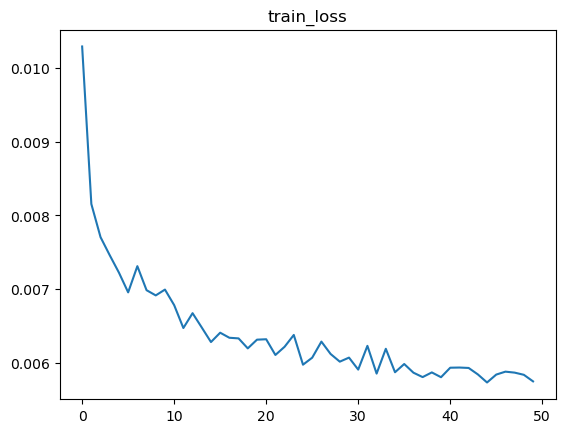

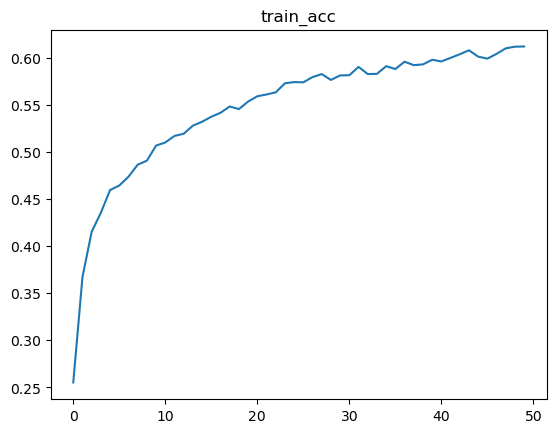

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [03:58<00:00,  4.88s/it]

Experiment cifar+adv-sample+dp+1024: Val accuracy: (0.0013074882388114928, 0.61074)
Experiment cifar+adv-sample+dp+1024: Training finished with epsilon 2.499231243449186


In [10]:
#90 clean - 10 adv
torch.cuda.empty_cache() 
ex = Experiment_weighted(
    batch_size=1024, 
    epochs=50, 
    adv_attack=torchattacks.FFGSM, 
    adv_attack_mode='sample', 
    adv_params={'eps':8/255}, 
    dp=True, 
    device=device, 
    save_experiment=False, 
    verbose=True, 
    target_epsilon=2.5, 
    dataset='cifar', 
    adv_test=True, 
    max_batch_size=256)

ex.run()

In [11]:
ex._run_epoch(ex.test_loader, eval=True)

100%|███████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:05<00:00, 80.00it/s]


(1.3998551276723055, 0.595)

Experiment cifar+adv-batch+dp+1024: Loading data
Files already downloaded and verified
Files already downloaded and verified
Experiment cifar+adv-batch+dp+1024: DP on
Experiment cifar+adv-batch+dp+1024: Training started


218it [00:31,  6.95it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   1/50, train loss: 9.96e-03, train acc: 0.222


222it [00:31,  6.99it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   2/50, train loss: 8.58e-03, train acc: 0.313


220it [00:32,  6.86it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   3/50, train loss: 8.17e-03, train acc: 0.339


218it [00:32,  6.77it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   4/50, train loss: 7.91e-03, train acc: 0.360


216it [00:32,  6.72it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   5/50, train loss: 7.78e-03, train acc: 0.361


215it [00:32,  6.66it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   6/50, train loss: 7.66e-03, train acc: 0.370


219it [00:32,  6.78it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   7/50, train loss: 7.70e-03, train acc: 0.378


214it [00:32,  6.68it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   8/50, train loss: 7.51e-03, train acc: 0.377


214it [00:31,  6.71it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   9/50, train loss: 7.51e-03, train acc: 0.379


214it [00:32,  6.66it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  10/50, train loss: 7.44e-03, train acc: 0.388


219it [00:32,  6.82it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  11/50, train loss: 7.60e-03, train acc: 0.389


223it [00:32,  6.88it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  12/50, train loss: 7.69e-03, train acc: 0.399


220it [00:32,  6.82it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  13/50, train loss: 7.56e-03, train acc: 0.403


212it [00:31,  6.65it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  14/50, train loss: 7.28e-03, train acc: 0.399


218it [00:32,  6.75it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  15/50, train loss: 7.46e-03, train acc: 0.410


218it [00:32,  6.78it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  16/50, train loss: 7.47e-03, train acc: 0.405


214it [00:32,  6.66it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  17/50, train loss: 7.26e-03, train acc: 0.418


218it [00:32,  6.76it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  18/50, train loss: 7.44e-03, train acc: 0.419


216it [00:31,  6.76it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  19/50, train loss: 7.28e-03, train acc: 0.416


219it [00:32,  6.77it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  20/50, train loss: 7.37e-03, train acc: 0.420


216it [00:32,  6.69it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  21/50, train loss: 7.22e-03, train acc: 0.425


227it [00:32,  6.95it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  22/50, train loss: 7.62e-03, train acc: 0.432


217it [00:32,  6.73it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  23/50, train loss: 7.21e-03, train acc: 0.430


213it [00:32,  6.64it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  24/50, train loss: 7.04e-03, train acc: 0.429


222it [00:32,  6.83it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  25/50, train loss: 7.36e-03, train acc: 0.432


218it [00:32,  6.79it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  26/50, train loss: 7.23e-03, train acc: 0.432


223it [00:32,  6.84it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  27/50, train loss: 7.36e-03, train acc: 0.437


214it [00:32,  6.67it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  28/50, train loss: 7.13e-03, train acc: 0.425


226it [00:32,  6.97it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  29/50, train loss: 7.55e-03, train acc: 0.431


222it [00:32,  6.88it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  30/50, train loss: 7.39e-03, train acc: 0.435


214it [00:32,  6.67it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  31/50, train loss: 7.06e-03, train acc: 0.438


213it [00:32,  6.63it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  32/50, train loss: 7.08e-03, train acc: 0.436


213it [00:32,  6.65it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  33/50, train loss: 7.03e-03, train acc: 0.432


219it [00:32,  6.81it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  34/50, train loss: 7.26e-03, train acc: 0.437


216it [00:32,  6.72it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  35/50, train loss: 7.12e-03, train acc: 0.439


220it [00:32,  6.78it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  36/50, train loss: 7.22e-03, train acc: 0.440


215it [00:32,  6.68it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  37/50, train loss: 7.06e-03, train acc: 0.439


220it [00:32,  6.83it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  38/50, train loss: 7.22e-03, train acc: 0.442


215it [00:31,  6.72it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  39/50, train loss: 7.05e-03, train acc: 0.437


218it [00:32,  6.75it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  40/50, train loss: 7.10e-03, train acc: 0.444


217it [00:32,  6.74it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  41/50, train loss: 7.14e-03, train acc: 0.443


217it [00:32,  6.77it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  42/50, train loss: 7.12e-03, train acc: 0.444


219it [00:32,  6.76it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  43/50, train loss: 7.18e-03, train acc: 0.444


219it [00:32,  6.80it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  44/50, train loss: 7.25e-03, train acc: 0.446


213it [00:31,  6.68it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  45/50, train loss: 6.94e-03, train acc: 0.446


220it [00:32,  6.82it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  46/50, train loss: 7.15e-03, train acc: 0.449


216it [00:32,  6.69it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  47/50, train loss: 7.07e-03, train acc: 0.450


214it [00:32,  6.68it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  48/50, train loss: 7.08e-03, train acc: 0.440


219it [00:32,  6.78it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  49/50, train loss: 7.18e-03, train acc: 0.451


214it [00:32,  6.64it/s]                                                                                                          

Experiment cifar+adv-batch+dp+1024: Epoch  50/50, train loss: 7.00e-03, train acc: 0.449


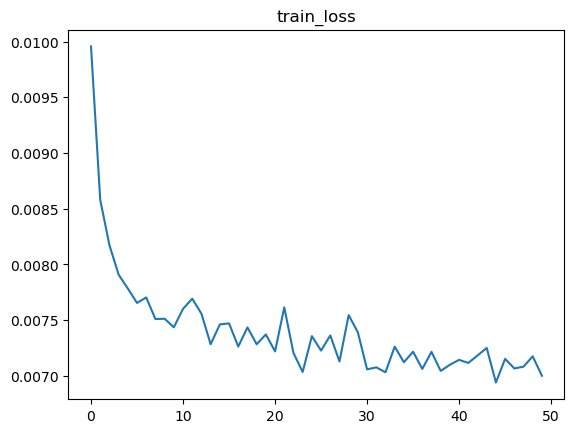

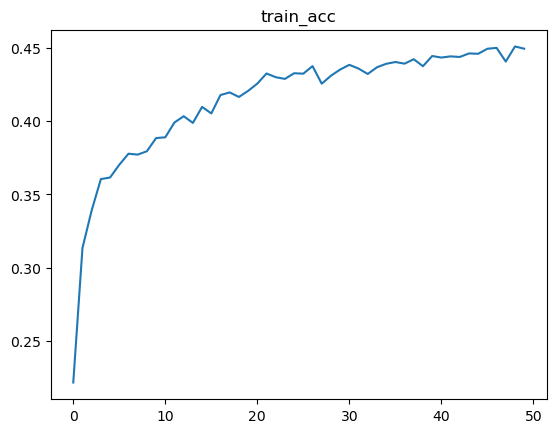

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:08<00:00,  5.77it/s]

Experiment cifar+adv-batch+dp+1024: Val accuracy: (0.001592413206100464, 0.45022)
Experiment cifar+adv-batch+dp+1024: Training finished with epsilon 0.9910639942617069


In [20]:
# 50 clean -50 adv
torch.cuda.empty_cache() 
ex = Experiment_weighted(
    batch_size=1024, 
    epochs=50, 
    adv_attack=torchattacks.FFGSM, 
    adv_attack_mode='batch', 
    adv_params={'eps':8/255}, 
    dp=True, 
    device=device, 
    save_experiment=False, 
    verbose=True, 
    target_epsilon=2.5, 
    dataset='cifar', 
    adv_test=True, 
    max_batch_size=256)

ex.run()

In [21]:
ex._run_epoch(ex.test_loader, eval=True)

100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:37<00:00, 102.56it/s]


(1.6210785047485374, 0.4508)

Experiment cifar+adv-batch+dp+1024: Loading data
Files already downloaded and verified
Files already downloaded and verified
Experiment cifar+adv-batch+dp+1024: DP on
Experiment cifar+adv-batch+dp+1024: Training started


802it [00:56, 14.15it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   1/50, train loss: 3.60e-02, train acc: 0.237


808it [00:57, 14.11it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   2/50, train loss: 3.08e-02, train acc: 0.332


806it [00:57, 13.92it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   3/50, train loss: 2.93e-02, train acc: 0.367


808it [00:58, 13.88it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   4/50, train loss: 2.93e-02, train acc: 0.377


804it [00:57, 13.97it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   5/50, train loss: 2.86e-02, train acc: 0.388


801it [00:57, 13.95it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   6/50, train loss: 2.80e-02, train acc: 0.401


806it [00:57, 13.98it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   7/50, train loss: 2.79e-02, train acc: 0.407


806it [00:57, 13.99it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   8/50, train loss: 2.77e-02, train acc: 0.416


807it [00:58, 13.76it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   9/50, train loss: 2.75e-02, train acc: 0.425


804it [00:57, 13.99it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  10/50, train loss: 2.70e-02, train acc: 0.429


802it [00:58, 13.78it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  11/50, train loss: 2.69e-02, train acc: 0.433


801it [00:57, 13.85it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  12/50, train loss: 2.69e-02, train acc: 0.432


803it [00:57, 13.99it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  13/50, train loss: 2.69e-02, train acc: 0.437


805it [00:57, 14.02it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  14/50, train loss: 2.66e-02, train acc: 0.447


800it [00:57, 13.80it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  15/50, train loss: 2.63e-02, train acc: 0.451


804it [00:58, 13.71it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  16/50, train loss: 2.65e-02, train acc: 0.454


804it [00:57, 13.93it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  17/50, train loss: 2.65e-02, train acc: 0.455


803it [00:57, 13.94it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  18/50, train loss: 2.67e-02, train acc: 0.457


809it [00:58, 13.79it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  19/50, train loss: 2.70e-02, train acc: 0.465


802it [00:57, 13.99it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  20/50, train loss: 2.66e-02, train acc: 0.462


804it [00:58, 13.82it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  21/50, train loss: 2.66e-02, train acc: 0.464


797it [00:57, 13.83it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  22/50, train loss: 2.61e-02, train acc: 0.463


812it [00:58, 13.98it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  23/50, train loss: 2.67e-02, train acc: 0.469


804it [00:57, 13.95it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  24/50, train loss: 2.63e-02, train acc: 0.467


808it [00:57, 13.96it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  25/50, train loss: 2.65e-02, train acc: 0.473


804it [00:57, 13.89it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  26/50, train loss: 2.64e-02, train acc: 0.472


800it [00:57, 13.91it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  27/50, train loss: 2.63e-02, train acc: 0.473


806it [00:57, 13.90it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  28/50, train loss: 2.63e-02, train acc: 0.477


805it [00:57, 13.93it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  29/50, train loss: 2.60e-02, train acc: 0.479


804it [00:57, 13.93it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  30/50, train loss: 2.61e-02, train acc: 0.479


813it [00:58, 13.84it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  31/50, train loss: 2.69e-02, train acc: 0.484


804it [00:57, 13.91it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  32/50, train loss: 2.65e-02, train acc: 0.476


801it [00:57, 14.02it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  33/50, train loss: 2.60e-02, train acc: 0.480


804it [00:57, 13.92it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  34/50, train loss: 2.63e-02, train acc: 0.484


808it [00:58, 13.90it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  35/50, train loss: 2.64e-02, train acc: 0.488


802it [00:58, 13.82it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  36/50, train loss: 2.62e-02, train acc: 0.485


808it [00:57, 14.01it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  37/50, train loss: 2.64e-02, train acc: 0.489


806it [00:57, 13.98it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  38/50, train loss: 2.61e-02, train acc: 0.489


801it [00:57, 13.92it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  39/50, train loss: 2.62e-02, train acc: 0.487


807it [00:58, 13.78it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  40/50, train loss: 2.65e-02, train acc: 0.493


805it [00:57, 13.93it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  41/50, train loss: 2.68e-02, train acc: 0.485


802it [00:57, 13.97it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  42/50, train loss: 2.60e-02, train acc: 0.492


804it [00:57, 13.92it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  43/50, train loss: 2.59e-02, train acc: 0.495


809it [00:58, 13.95it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  44/50, train loss: 2.63e-02, train acc: 0.499


806it [00:57, 13.98it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  45/50, train loss: 2.62e-02, train acc: 0.499


801it [00:57, 13.88it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  46/50, train loss: 2.59e-02, train acc: 0.502


807it [00:57, 14.00it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  47/50, train loss: 2.61e-02, train acc: 0.501


796it [00:58, 13.71it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  48/50, train loss: 2.58e-02, train acc: 0.493


796it [00:57, 13.79it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  49/50, train loss: 2.59e-02, train acc: 0.496


805it [00:57, 13.94it/s]                                                                                                          

Experiment cifar+adv-batch+dp+1024: Epoch  50/50, train loss: 2.62e-02, train acc: 0.498


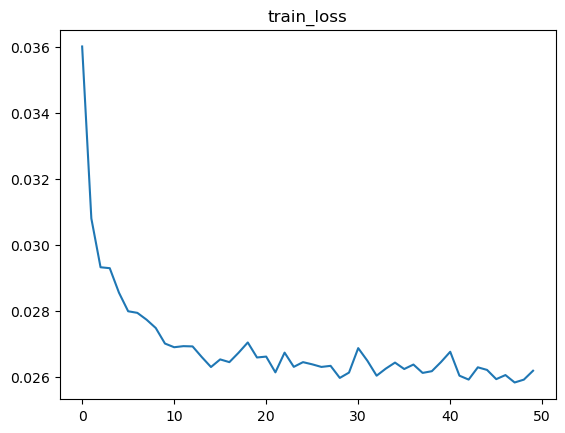

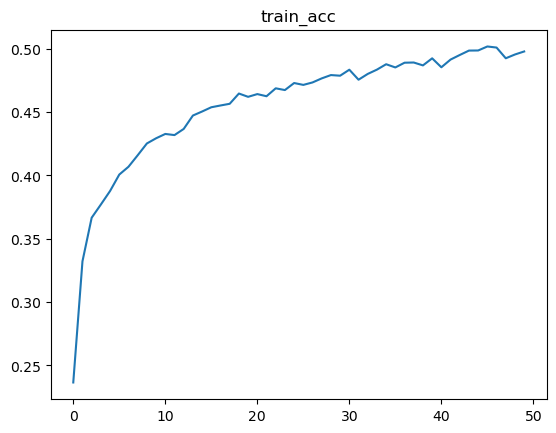

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s]

Experiment cifar+adv-batch+dp+1024: Val accuracy: (0.0015881206846237183, 0.49582)
Experiment cifar+adv-batch+dp+1024: Training finished with epsilon 0.9910639942617069


In [31]:
#90 clean - 10 adv
torch.cuda.empty_cache() 
ex = Experiment_weighted(
    batch_size=1024, 
    epochs=50, 
    adv_attack=torchattacks.PGD, 
    adv_attack_mode='batch', 
    adv_params={'eps':8/255, 'alpha':1/255, 'steps':5, 'random_start':True}, 
    dp=True, 
    device=device, 
    save_experiment=False, 
    verbose=True, 
    target_epsilon=2.5, 
    dataset='cifar', 
    adv_test=True, 
    max_batch_size=64)
ex.run()

In [32]:
ex._run_epoch(ex.test_loader, eval=True)

100%|███████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:54<00:00, 42.67it/s]


(1.6639486350606865, 0.4943)

Experiment cifar+adv-batch+dp+1024: Loading data
Files already downloaded and verified
Files already downloaded and verified
Experiment cifar+adv-batch+dp+1024: DP on
Experiment cifar+adv-batch+dp+1024: Training started


413it [00:52,  7.91it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   1/50, train loss: 1.86e-02, train acc: 0.233


412it [00:53,  7.70it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   2/50, train loss: 1.57e-02, train acc: 0.326


416it [00:54,  7.70it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   3/50, train loss: 1.52e-02, train acc: 0.362


414it [00:53,  7.67it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   4/50, train loss: 1.48e-02, train acc: 0.383


416it [00:54,  7.70it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   5/50, train loss: 1.47e-02, train acc: 0.395


413it [00:53,  7.70it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   6/50, train loss: 1.44e-02, train acc: 0.402


412it [00:53,  7.70it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   7/50, train loss: 1.44e-02, train acc: 0.403


410it [00:53,  7.66it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   8/50, train loss: 1.43e-02, train acc: 0.410


413it [00:53,  7.71it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   9/50, train loss: 1.43e-02, train acc: 0.414


412it [00:53,  7.73it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  10/50, train loss: 1.42e-02, train acc: 0.421


409it [00:53,  7.67it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  11/50, train loss: 1.39e-02, train acc: 0.432


413it [00:53,  7.71it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  12/50, train loss: 1.40e-02, train acc: 0.441


413it [00:53,  7.70it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  13/50, train loss: 1.39e-02, train acc: 0.444


414it [00:53,  7.67it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  14/50, train loss: 1.39e-02, train acc: 0.450


413it [00:53,  7.72it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  15/50, train loss: 1.39e-02, train acc: 0.447


414it [00:53,  7.73it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  16/50, train loss: 1.38e-02, train acc: 0.449


408it [00:53,  7.67it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  17/50, train loss: 1.35e-02, train acc: 0.446


417it [00:53,  7.80it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  18/50, train loss: 1.38e-02, train acc: 0.455


415it [00:53,  7.76it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  19/50, train loss: 1.38e-02, train acc: 0.456


411it [00:53,  7.71it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  20/50, train loss: 1.36e-02, train acc: 0.456


415it [00:53,  7.75it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  21/50, train loss: 1.36e-02, train acc: 0.464


419it [00:53,  7.81it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  22/50, train loss: 1.38e-02, train acc: 0.468


409it [00:53,  7.71it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  23/50, train loss: 1.36e-02, train acc: 0.463


410it [00:53,  7.67it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  24/50, train loss: 1.36e-02, train acc: 0.465


411it [00:53,  7.69it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  25/50, train loss: 1.35e-02, train acc: 0.470


416it [00:53,  7.75it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  26/50, train loss: 1.35e-02, train acc: 0.476


414it [00:53,  7.73it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  27/50, train loss: 1.34e-02, train acc: 0.478


418it [00:53,  7.76it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  28/50, train loss: 1.36e-02, train acc: 0.477


417it [00:53,  7.73it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  29/50, train loss: 1.35e-02, train acc: 0.483


417it [00:53,  7.78it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  30/50, train loss: 1.37e-02, train acc: 0.480


415it [00:53,  7.72it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  31/50, train loss: 1.36e-02, train acc: 0.483


413it [00:53,  7.71it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  32/50, train loss: 1.35e-02, train acc: 0.488


413it [00:53,  7.71it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  33/50, train loss: 1.34e-02, train acc: 0.492


412it [00:53,  7.70it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  34/50, train loss: 1.33e-02, train acc: 0.492


416it [00:53,  7.77it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  35/50, train loss: 1.35e-02, train acc: 0.491


413it [00:53,  7.72it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  36/50, train loss: 1.32e-02, train acc: 0.494


406it [00:53,  7.64it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  37/50, train loss: 1.31e-02, train acc: 0.491


414it [00:53,  7.73it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  38/50, train loss: 1.33e-02, train acc: 0.496


412it [00:53,  7.70it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  39/50, train loss: 1.32e-02, train acc: 0.501


416it [00:53,  7.78it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  40/50, train loss: 1.33e-02, train acc: 0.502


414it [00:53,  7.72it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  41/50, train loss: 1.32e-02, train acc: 0.502


408it [00:53,  7.64it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  42/50, train loss: 1.29e-02, train acc: 0.501


414it [00:53,  7.74it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  43/50, train loss: 1.31e-02, train acc: 0.502


415it [00:53,  7.76it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  44/50, train loss: 1.33e-02, train acc: 0.505


417it [00:53,  7.78it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  45/50, train loss: 1.36e-02, train acc: 0.503


418it [00:53,  7.77it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  46/50, train loss: 1.36e-02, train acc: 0.510


416it [00:53,  7.78it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  47/50, train loss: 1.32e-02, train acc: 0.508


417it [00:53,  7.74it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  48/50, train loss: 1.32e-02, train acc: 0.516


417it [00:53,  7.76it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  49/50, train loss: 1.34e-02, train acc: 0.510


416it [00:53,  7.73it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  50/50, train loss: 1.32e-02, train acc: 0.515


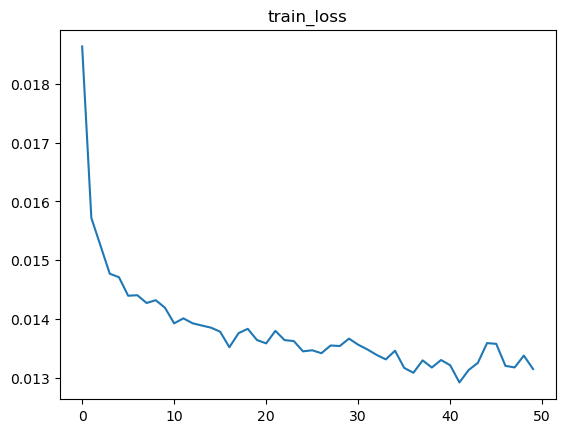

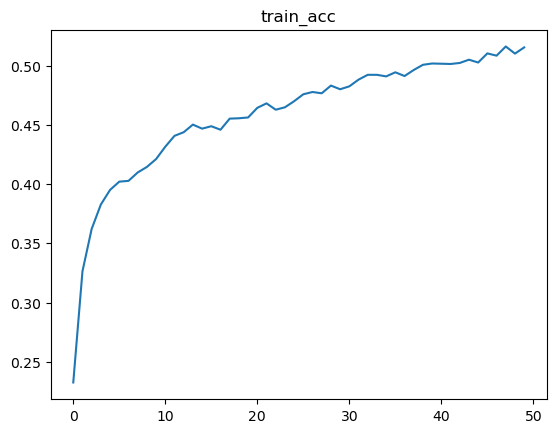

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:29<00:00,  1.67it/s]

Experiment cifar+adv-batch+dp+1024: Val accuracy: (0.0015430382752418517, 0.51404)
Experiment cifar+adv-batch+dp+1024: Training finished with epsilon 0.9910639942617069


In [33]:
#90 clean - 10 adv
torch.cuda.empty_cache() 
ex = Experiment_weighted(
    batch_size=1024, 
    epochs=50, 
    adv_attack=torchattacks.PGD, 
    adv_attack_mode='batch', 
    adv_params={'eps':8/255, 'alpha':1/255, 'steps':5, 'random_start':True}, 
    dp=True, 
    device=device, 
    save_experiment=False, 
    verbose=True, 
    target_epsilon=2.5, 
    dataset='cifar', 
    adv_test=True, 
    max_batch_size=128)
ex.run()

In [34]:
ex._run_epoch(ex.test_loader, eval=True)

100%|███████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:48<00:00, 43.82it/s]


(1.617576632647268, 0.5039)

Experiment cifar+adv-batch+dp+1024: Loading data
Files already downloaded and verified
Files already downloaded and verified
Experiment cifar+adv-batch+dp+1024: DP on
Experiment cifar+adv-batch+dp+1024: Training started


406it [00:33, 12.22it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   1/25, train loss: 1.79e-02, train acc: 0.252


407it [00:33, 12.10it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   2/25, train loss: 1.50e-02, train acc: 0.358


414it [00:34, 12.16it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   3/25, train loss: 1.45e-02, train acc: 0.393


409it [00:33, 12.05it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   4/25, train loss: 1.41e-02, train acc: 0.407


414it [00:34, 12.12it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   5/25, train loss: 1.39e-02, train acc: 0.427


417it [00:34, 12.24it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   6/25, train loss: 1.38e-02, train acc: 0.441


405it [00:33, 12.03it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   7/25, train loss: 1.33e-02, train acc: 0.443


406it [00:33, 12.04it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   8/25, train loss: 1.32e-02, train acc: 0.451


416it [00:34, 12.19it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   9/25, train loss: 1.35e-02, train acc: 0.463


407it [00:33, 12.07it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  10/25, train loss: 1.31e-02, train acc: 0.458


420it [00:34, 12.28it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  11/25, train loss: 1.34e-02, train acc: 0.474


412it [00:33, 12.12it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  12/25, train loss: 1.30e-02, train acc: 0.477


413it [00:33, 12.19it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  13/25, train loss: 1.29e-02, train acc: 0.479


409it [00:33, 12.13it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  14/25, train loss: 1.28e-02, train acc: 0.484


416it [00:33, 12.27it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  15/25, train loss: 1.30e-02, train acc: 0.485


416it [00:34, 12.16it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  16/25, train loss: 1.29e-02, train acc: 0.494


423it [00:34, 12.33it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  17/25, train loss: 1.32e-02, train acc: 0.494


414it [00:33, 12.21it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  18/25, train loss: 1.31e-02, train acc: 0.489


413it [00:33, 12.23it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  19/25, train loss: 1.31e-02, train acc: 0.486


414it [00:33, 12.22it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  20/25, train loss: 1.29e-02, train acc: 0.494


415it [00:34, 12.15it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  21/25, train loss: 1.30e-02, train acc: 0.499


422it [00:34, 12.36it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  22/25, train loss: 1.32e-02, train acc: 0.502


412it [00:33, 12.12it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  23/25, train loss: 1.28e-02, train acc: 0.506


413it [00:33, 12.18it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  24/25, train loss: 1.30e-02, train acc: 0.500


413it [00:33, 12.18it/s]                                                                                                          

Experiment cifar+adv-batch+dp+1024: Epoch  25/25, train loss: 1.28e-02, train acc: 0.509


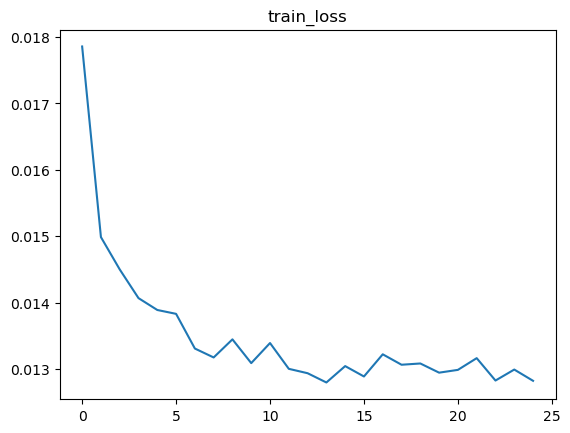

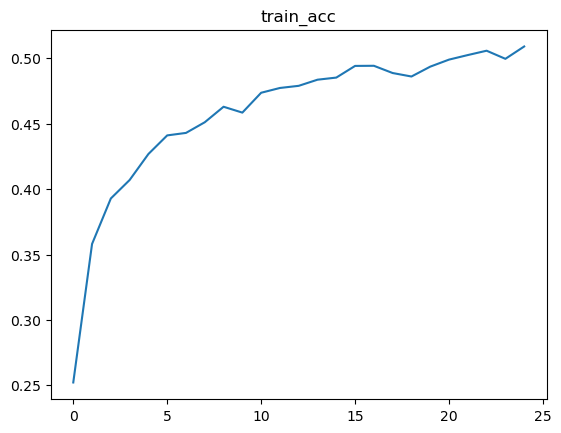

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:08<00:00,  5.69it/s]

Experiment cifar+adv-batch+dp+1024: Val accuracy: (0.0015208093333244324, 0.51814)
Experiment cifar+adv-batch+dp+1024: Training finished with epsilon 0.9930328597179366


In [35]:
#90 clean - 10 adv
torch.cuda.empty_cache() 
ex = Experiment_weighted(
    batch_size=1024, 
    epochs=25, 
    adv_attack=torchattacks.FFGSM, 
    adv_attack_mode='batch', 
    adv_params={'eps':8/255}, 
    dp=True, 
    device=device, 
    save_experiment=False, 
    verbose=True, 
    target_epsilon=2.5, 
    dataset='cifar', 
    adv_test=True, 
    max_batch_size=128)

ex.run()

In [36]:
ex._run_epoch(ex.test_loader, eval=True)

100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:38<00:00, 101.53it/s]


(1.6014782116500574, 0.4971)

Experiment cifar+adv-batch+dp+1024: Loading data
Files already downloaded and verified
Files already downloaded and verified
Experiment cifar+adv-batch+dp+1024: DP on
Experiment cifar+adv-batch+dp+1024: Training started


413it [00:52,  7.83it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   1/25, train loss: 1.82e-02, train acc: 0.253


408it [00:53,  7.58it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   2/25, train loss: 1.47e-02, train acc: 0.371


413it [00:53,  7.68it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   3/25, train loss: 1.43e-02, train acc: 0.399


410it [00:53,  7.70it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   4/25, train loss: 1.40e-02, train acc: 0.409


418it [00:53,  7.75it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   5/25, train loss: 1.39e-02, train acc: 0.429


414it [00:53,  7.68it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   6/25, train loss: 1.37e-02, train acc: 0.437


414it [00:53,  7.73it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   7/25, train loss: 1.37e-02, train acc: 0.443


408it [00:53,  7.66it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   8/25, train loss: 1.33e-02, train acc: 0.449


411it [00:53,  7.65it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   9/25, train loss: 1.33e-02, train acc: 0.462


415it [00:53,  7.71it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  10/25, train loss: 1.35e-02, train acc: 0.466


415it [00:53,  7.74it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  11/25, train loss: 1.34e-02, train acc: 0.466


421it [00:53,  7.80it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  12/25, train loss: 1.38e-02, train acc: 0.473


415it [00:53,  7.76it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  13/25, train loss: 1.32e-02, train acc: 0.480


411it [00:53,  7.70it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  14/25, train loss: 1.31e-02, train acc: 0.484


417it [00:53,  7.78it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  15/25, train loss: 1.32e-02, train acc: 0.488


414it [00:53,  7.73it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  16/25, train loss: 1.31e-02, train acc: 0.490


415it [00:53,  7.73it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  17/25, train loss: 1.31e-02, train acc: 0.496


413it [00:53,  7.74it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  18/25, train loss: 1.29e-02, train acc: 0.497


413it [00:53,  7.73it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  19/25, train loss: 1.30e-02, train acc: 0.497


423it [00:54,  7.81it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  20/25, train loss: 1.33e-02, train acc: 0.504


414it [00:53,  7.73it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  21/25, train loss: 1.29e-02, train acc: 0.507


421it [00:54,  7.79it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  22/25, train loss: 1.32e-02, train acc: 0.512


417it [00:53,  7.76it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  23/25, train loss: 1.31e-02, train acc: 0.508


409it [00:53,  7.65it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  24/25, train loss: 1.26e-02, train acc: 0.513


417it [00:53,  7.75it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  25/25, train loss: 1.29e-02, train acc: 0.514


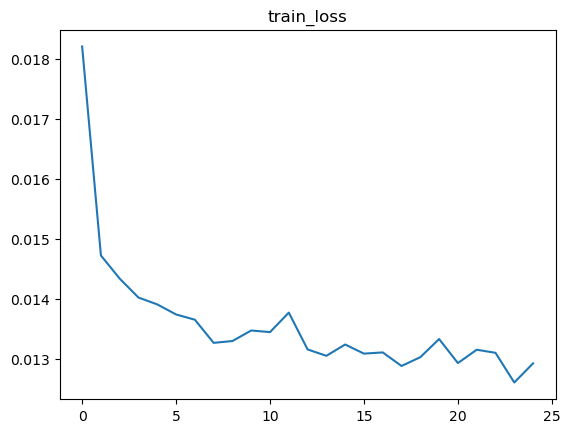

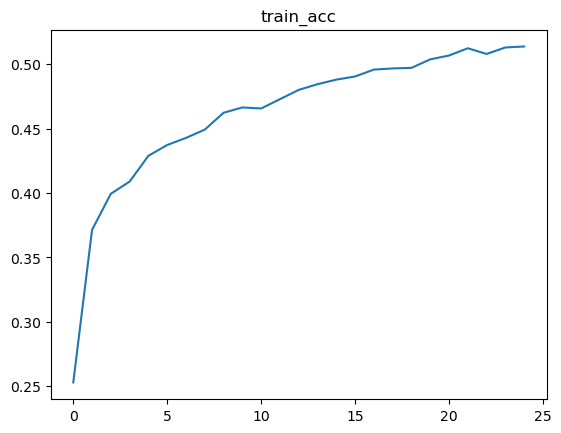

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s]

Experiment cifar+adv-batch+dp+1024: Val accuracy: (0.0015167124009132385, 0.51766)
Experiment cifar+adv-batch+dp+1024: Training finished with epsilon 0.9930328597179366


In [37]:
#90 clean - 10 adv
torch.cuda.empty_cache() 
ex = Experiment_weighted(
    batch_size=1024, 
    epochs=25, 
    adv_attack=torchattacks.PGD, 
    adv_attack_mode='batch', 
    adv_params={'eps':8/255, 'alpha':1/255, 'steps':5, 'random_start':True}, 
    dp=True, 
    device=device, 
    save_experiment=False, 
    verbose=True, 
    target_epsilon=2.5, 
    dataset='cifar', 
    adv_test=True, 
    max_batch_size=128)
ex.run()

In [38]:
ex._run_epoch(ex.test_loader, eval=True)

100%|███████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:48<00:00, 43.84it/s]


(1.588708283187426, 0.5061)

Experiment cifar+adv-batch+dp+1024: Loading data
Files already downloaded and verified
Files already downloaded and verified
Experiment cifar+adv-batch+dp+1024: DP on
Experiment cifar+adv-batch+dp+1024: Training started


416it [00:53,  7.82it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   1/25, train loss: 1.86e-02, train acc: 0.257


416it [00:54,  7.68it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   2/25, train loss: 1.53e-02, train acc: 0.360


414it [00:54,  7.65it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   3/25, train loss: 1.46e-02, train acc: 0.385


417it [00:54,  7.59it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   4/25, train loss: 1.44e-02, train acc: 0.407


420it [00:54,  7.64it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   5/25, train loss: 1.43e-02, train acc: 0.416


412it [00:54,  7.59it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   6/25, train loss: 1.39e-02, train acc: 0.427


411it [00:54,  7.57it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   7/25, train loss: 1.37e-02, train acc: 0.433


420it [00:54,  7.67it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   8/25, train loss: 1.38e-02, train acc: 0.442


410it [00:54,  7.54it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   9/25, train loss: 1.33e-02, train acc: 0.448


416it [00:54,  7.60it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  10/25, train loss: 1.35e-02, train acc: 0.461


410it [00:54,  7.58it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  11/25, train loss: 1.33e-02, train acc: 0.458


418it [00:54,  7.64it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  12/25, train loss: 1.34e-02, train acc: 0.472


418it [00:54,  7.62it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  13/25, train loss: 1.36e-02, train acc: 0.467


417it [00:54,  7.61it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  14/25, train loss: 1.34e-02, train acc: 0.473


417it [00:54,  7.63it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  15/25, train loss: 1.34e-02, train acc: 0.478


417it [00:54,  7.61it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  16/25, train loss: 1.33e-02, train acc: 0.478


414it [00:54,  7.61it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  17/25, train loss: 1.30e-02, train acc: 0.483


412it [00:54,  7.60it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  18/25, train loss: 1.29e-02, train acc: 0.482


413it [00:54,  7.58it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  19/25, train loss: 1.29e-02, train acc: 0.491


411it [00:54,  7.59it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  20/25, train loss: 1.28e-02, train acc: 0.489


420it [00:55,  7.62it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  21/25, train loss: 1.32e-02, train acc: 0.495


415it [00:54,  7.59it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  22/25, train loss: 1.28e-02, train acc: 0.497


414it [00:54,  7.62it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  23/25, train loss: 1.29e-02, train acc: 0.498


418it [00:54,  7.63it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  24/25, train loss: 1.30e-02, train acc: 0.505


416it [00:54,  7.61it/s]                                                                                                          

Experiment cifar+adv-batch+dp+1024: Epoch  25/25, train loss: 1.30e-02, train acc: 0.499


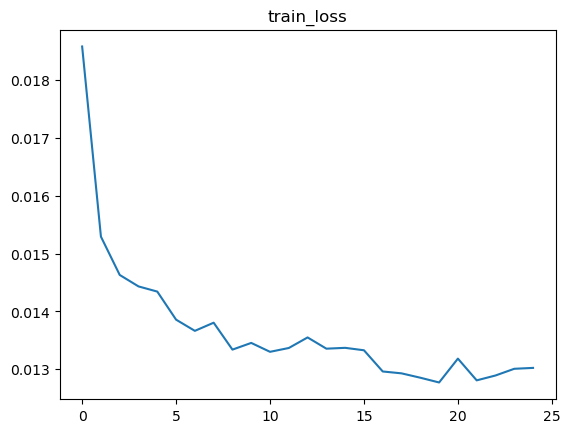

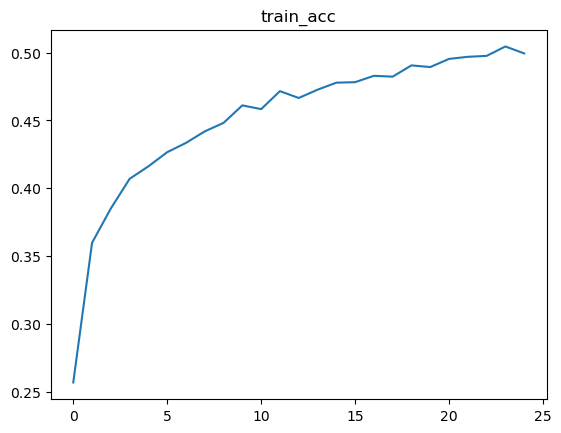

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:25<00:00,  1.91it/s]

Experiment cifar+adv-batch+dp+1024: Val accuracy: (0.0015194666719436645, 0.5055)
Experiment cifar+adv-batch+dp+1024: Training finished with epsilon 0.9930328597179366


In [44]:
#80 clean - 20 adv
torch.cuda.empty_cache() 
ex = Experiment_weighted(
    batch_size=1024, 
    epochs=25, 
    adv_attack=torchattacks.PGD, 
    adv_attack_mode='batch', 
    adv_params={'eps':8/255, 'alpha':1/255, 'steps':5, 'random_start':True}, 
    dp=True, 
    device=device, 
    save_experiment=False, 
    verbose=True, 
    target_epsilon=2.5, 
    dataset='cifar', 
    adv_test=True, 
    max_batch_size=128)
ex.run()

In [45]:
ex._run_epoch(ex.test_loader, eval=True)

100%|███████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:34<00:00, 29.94it/s]


(1.5565584544478093, 0.5074)

Experiment cifar+adv-batch+dp+1024: Loading data
Files already downloaded and verified
Files already downloaded and verified
Experiment cifar+adv-batch+dp+1024: DP on
Experiment cifar+adv-batch+dp+1024: Training started


418it [00:53,  7.82it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   1/25, train loss: 1.82e-02, train acc: 0.250


419it [00:54,  7.69it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   2/25, train loss: 1.55e-02, train acc: 0.350


420it [00:55,  7.61it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   3/25, train loss: 1.48e-02, train acc: 0.388


420it [00:55,  7.61it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   4/25, train loss: 1.44e-02, train acc: 0.410


409it [00:54,  7.52it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   5/25, train loss: 1.39e-02, train acc: 0.412


417it [00:54,  7.59it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   6/25, train loss: 1.41e-02, train acc: 0.424


412it [00:54,  7.57it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   7/25, train loss: 1.37e-02, train acc: 0.427


410it [00:54,  7.50it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   8/25, train loss: 1.35e-02, train acc: 0.436


407it [00:53,  7.54it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch   9/25, train loss: 1.32e-02, train acc: 0.445


421it [00:54,  7.67it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  10/25, train loss: 1.38e-02, train acc: 0.448


411it [00:54,  7.51it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  11/25, train loss: 1.34e-02, train acc: 0.455


408it [00:54,  7.53it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  12/25, train loss: 1.33e-02, train acc: 0.451


414it [00:54,  7.61it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  13/25, train loss: 1.34e-02, train acc: 0.456


419it [00:55,  7.61it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  14/25, train loss: 1.35e-02, train acc: 0.462


410it [00:54,  7.55it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  15/25, train loss: 1.32e-02, train acc: 0.462


411it [00:54,  7.59it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  16/25, train loss: 1.31e-02, train acc: 0.465


412it [00:54,  7.55it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  17/25, train loss: 1.31e-02, train acc: 0.470


412it [00:54,  7.59it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  18/25, train loss: 1.32e-02, train acc: 0.469


412it [00:54,  7.58it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  19/25, train loss: 1.31e-02, train acc: 0.475


422it [00:55,  7.65it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  20/25, train loss: 1.32e-02, train acc: 0.480


418it [00:54,  7.66it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  21/25, train loss: 1.32e-02, train acc: 0.474


413it [00:54,  7.58it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  22/25, train loss: 1.30e-02, train acc: 0.480


415it [00:54,  7.59it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  23/25, train loss: 1.31e-02, train acc: 0.480


414it [00:54,  7.61it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  24/25, train loss: 1.30e-02, train acc: 0.481


416it [00:54,  7.60it/s]                                                                                                          


Experiment cifar+adv-batch+dp+1024: Epoch  25/25, train loss: 1.31e-02, train acc: 0.481


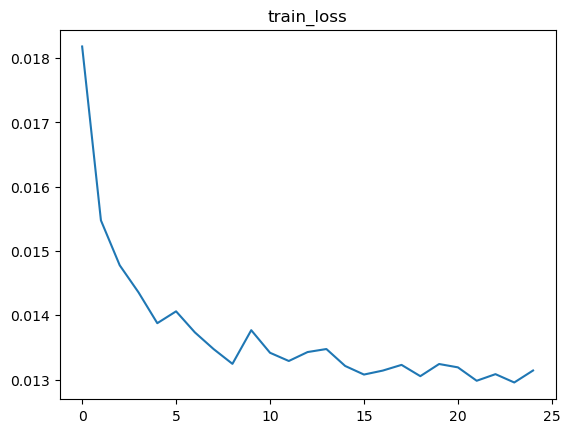

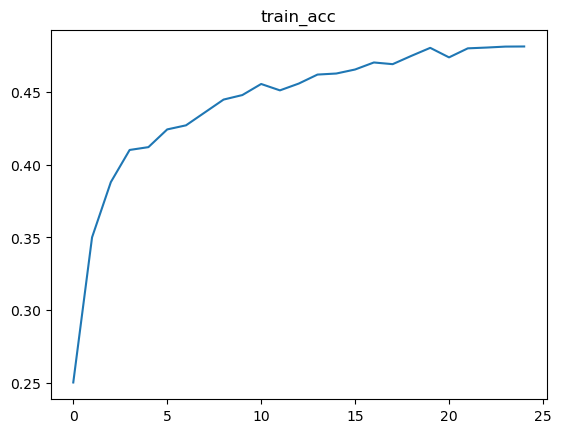

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:25<00:00,  1.90it/s]

Experiment cifar+adv-batch+dp+1024: Val accuracy: (0.0015479085445404054, 0.48176)
Experiment cifar+adv-batch+dp+1024: Training finished with epsilon 0.9930328597179366


In [47]:
#80 clean - 20 adv
torch.cuda.empty_cache() 
ex = Experiment_weighted(
    batch_size=1024, 
    epochs=25, 
    adv_attack=torchattacks.PGD, 
    adv_attack_mode='batch', 
    adv_params={'eps':8/255, 'alpha':1/255, 'steps':5, 'random_start':True}, 
    dp=True, 
    device=device, 
    save_experiment=False, 
    verbose=True, 
    target_epsilon=2.5, 
    dataset='cifar', 
    adv_test=True, 
    max_batch_size=128)
ex.run()

In [48]:
ex._run_epoch(ex.test_loader, eval=True)

100%|███████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [06:29<00:00, 25.67it/s]


(1.5944811903321445, 0.4741)